In [1]:
library(IRdisplay)
display_html("<style>.container { width:100% !important; }</style>")

.libPaths()

[1] "/hps/software/users/marioni/Leah/miniconda3/envs/basic_renv/lib/R/library"

In [2]:
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))
#suppressPackageStartupMessages(library(ggalluvial))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(gtools))
#library(ggsignif)
suppressPackageStartupMessages(library(viridis))
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(matrixStats))

source("plotting_settings.R")

In [3]:
g_meta <- fread('/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/sample_metadata_final.txt.gz')

cluster_grouping <- list('multipotent' = c('PGCs', 'Epiblast', 'Primitive Streak', 'Caudal Epiblast', 'NMPs'
),
'mesoderm' = c('Notochord', "Early Nascent Mesoderm", "Late Nascent Mesoderm", "Head Mesoderm",
               "Cardiopharyngeal Mesoderm", "Endothelium", "Early Posterior PSM", "Late Posterior PSM",
               "Early Anterior PSM", "Late Anterior PSM", "Somites", "Mature Somites"
),
'endoderm' = c('Anterior Primitive Streak', 'Mature Endoderm'),
'ectoderm' = c("Caudal Neurectoderm", "Early Spinal Cord", "Late Spinal Cord",
               "Early Neurectoderm", "Late Neurectoderm", "Neurons"
)
)
getgroupcols <- function(group, cts_toexcl=c()) {
  cols_to_agg <- cluster_grouping[[group]]
  cols_to_agg <- cols_to_agg[!(cols_to_agg %in% cts_toexcl)]
  tmp <- g_meta[cluster %in% cols_to_agg, .N,by=c("cluster")] %>% .[,prop := N/sum(N)] %>% as.data.frame
  rownames(tmp) <- tmp$cluster
  tmp2 <- Reduce(cbind, lapply(cols_to_agg, function(c) as.data.frame(col2rgb(cluster_colours[c]))))
  rgb_val <- round(colSums(t(tmp2) * tmp[colnames(tmp2),]$prop))
  return(rgb(round(rgb_val[['red']]),round(rgb_val[['green']]),round(rgb_val[['blue']]), maxColorValue=255))
}
group_colours = c(
  "multipotent" = getgroupcols('multipotent', cts_toexcl=c('NMPs')),
  "mesoderm" = getgroupcols('mesoderm', cts_toexcl=c("Cardiopharyngeal Mesoderm", 'Head Mesoderm', 'Endothelium')),
  "endoderm" = getgroupcols('endoderm'),
  "ectoderm" = getgroupcols('ectoderm')
)
group_order <- c('multipotent', 'endoderm', 'mesoderm', 'ectoderm')
inv_cluster_grouping <- split(as.character(stack(cluster_grouping)$ind), stack(cluster_grouping)$values)
group_colours['mesoderm'] <- '#459AC0'
group_colours['ectoderm'] <- '#99C463'
group_colours['endoderm'] <- '#F178AE'

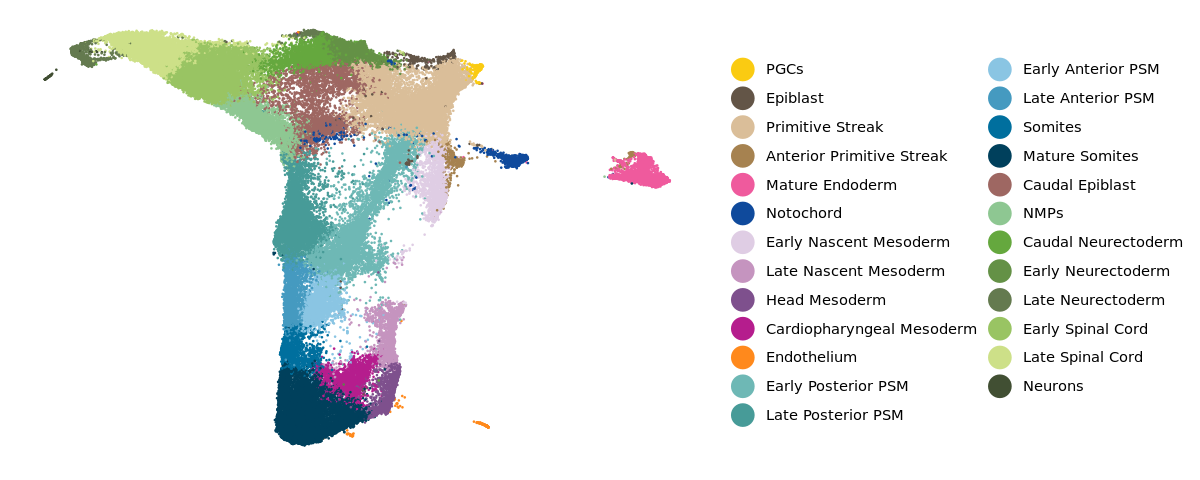

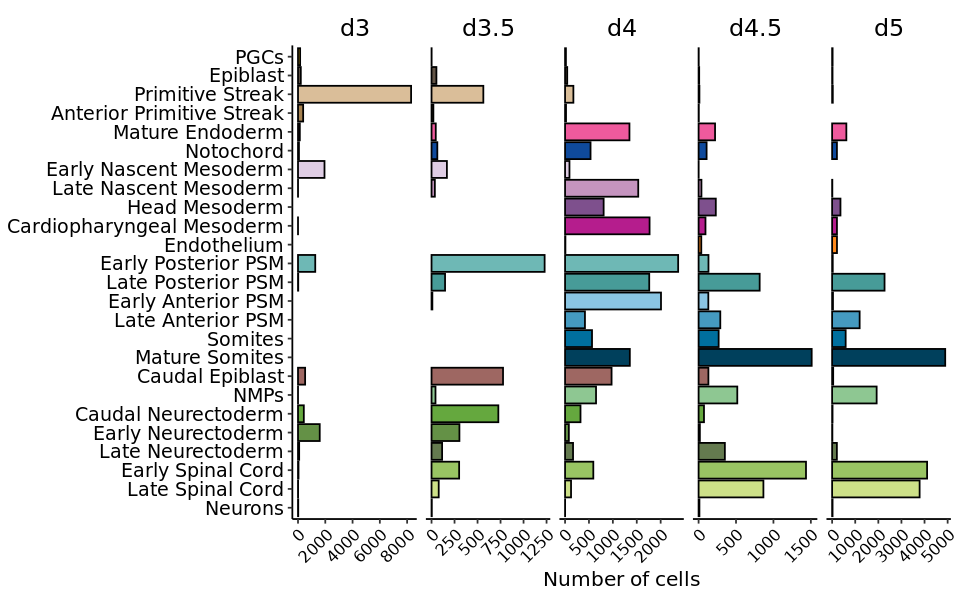

In [4]:
##############
## Figure 1 ##
##############

## Figure 1b
options(repr.plot.width=10, repr.plot.height=4)
to.plot <- g_meta
to.plot$cluster <- factor(to.plot$cluster, levels = rev(cluster_order))
p <- ggplot(data=to.plot, mapping = aes(x=X1, y=X2, colour=cluster)) +
  geom_point(size=0.1, alpha=1) +
  #ggrastr::geom_point_rast(size=0.1, alpha=1) +
  labs(x="UMAP Dimension 1", y="UMAP Dimension 2") +
  scale_colour_manual(values = cluster_colours[cluster_order], name = "Cell Type") +
  guides(colour = guide_legend(override.aes = list(size=6))) +
  theme_classic() +
  theme(line = element_blank(),
        axis.text=element_blank(),
        title = element_blank())
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/Fig1/B.pdf',
  plot = p,
  device = 'pdf',
  width = 10,
  height = 4,
  units = "in"
)

## Figure 1c
options(repr.plot.width=8, repr.plot.height=5)
to.plot <- g_meta[(timepoint %in% c('d3', 'd3.5', 'd4', 'd4.5', 'd5'))][,.N,by=c("cluster","timepoint")]
to.plot$cluster <- factor(to.plot$cluster, levels=rev(cluster_order))
p <- barplot.pub(to.plot, x="cluster", colors=cluster_colours) +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
  facet_wrap(~timepoint, nrow=1, scales="free_x")
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/Fig1/C.pdf',
  plot = p,
  device = 'pdf',
  width = 8,
  height = 5,
  units = "in"
)

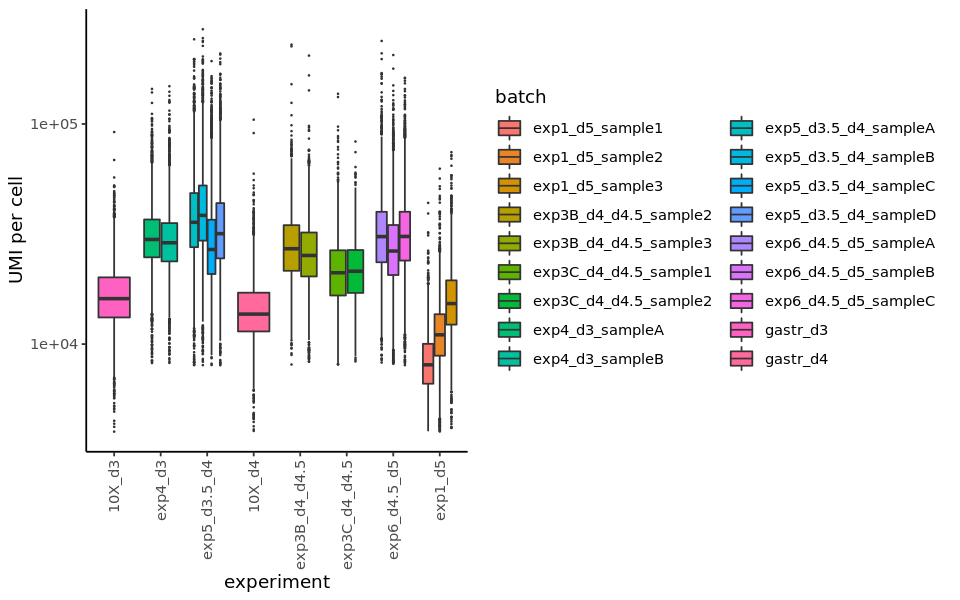

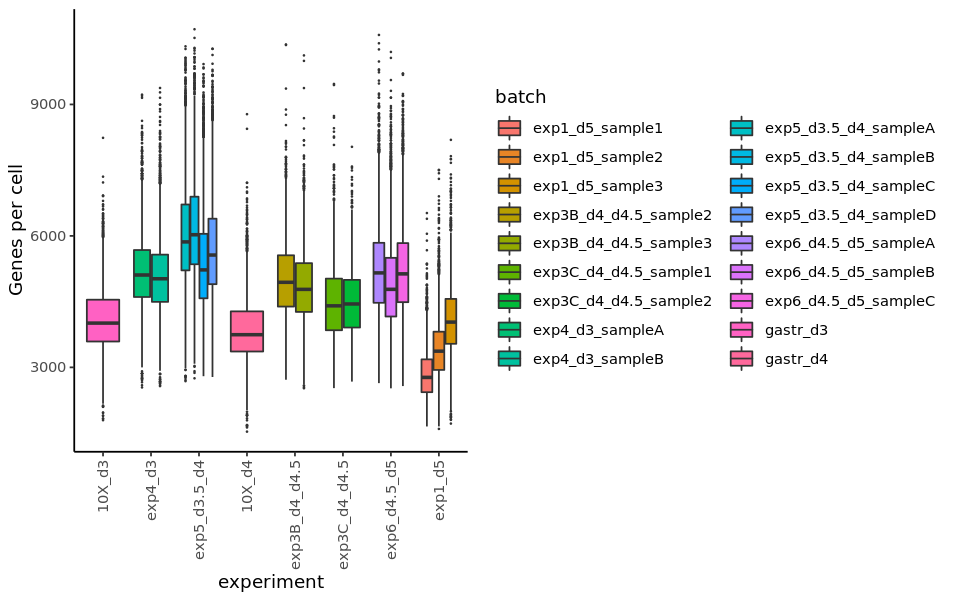

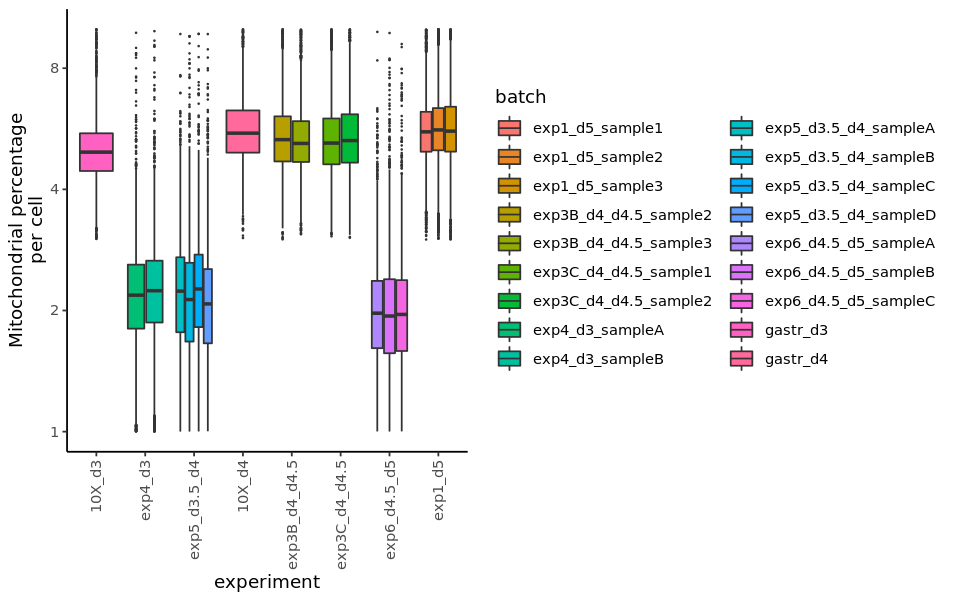

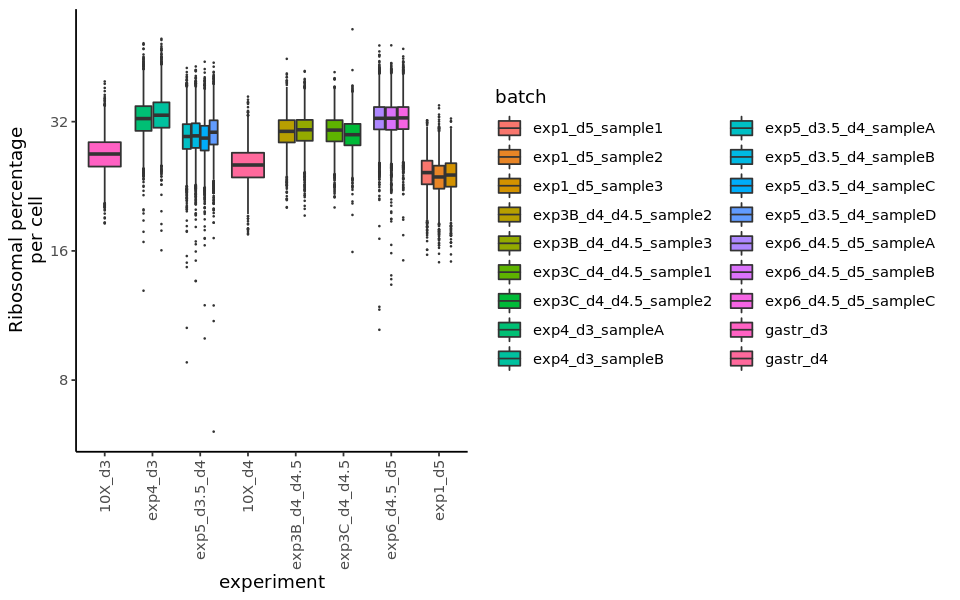

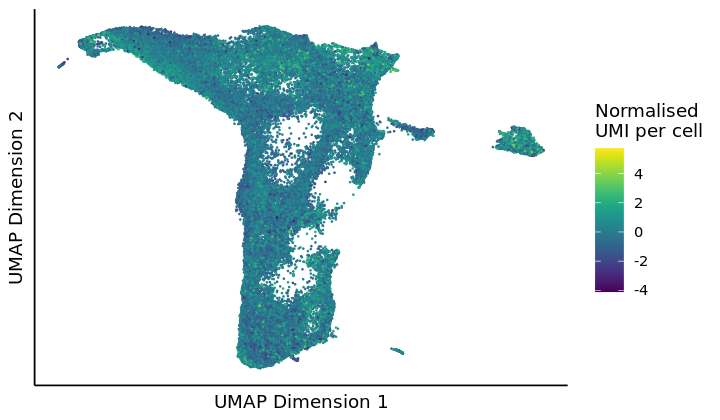

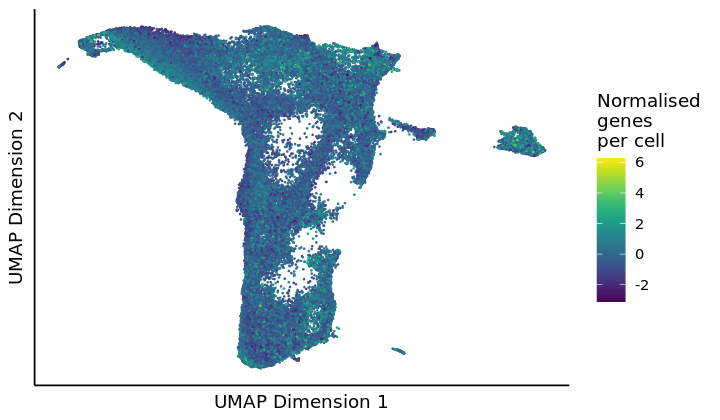

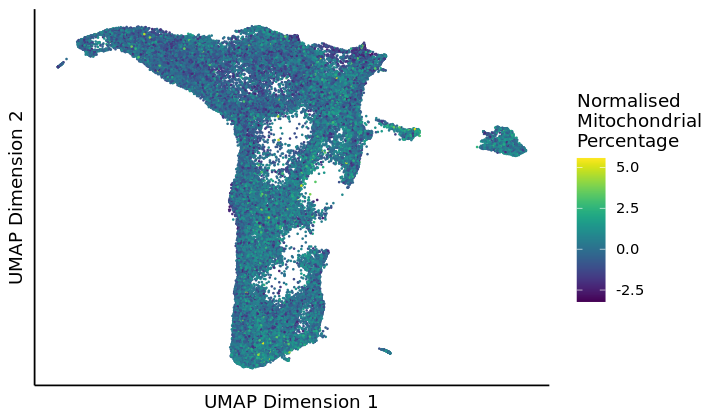

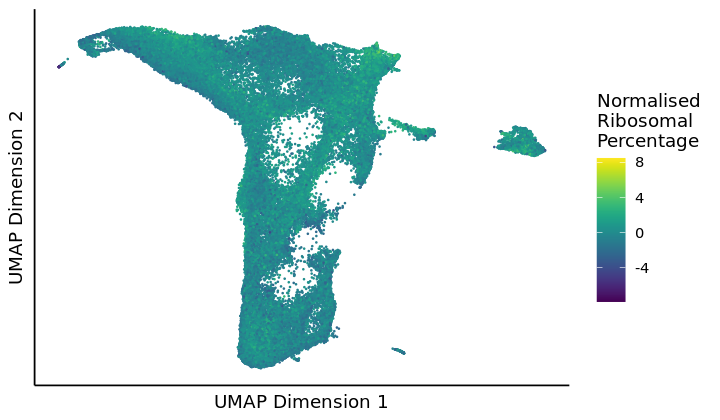

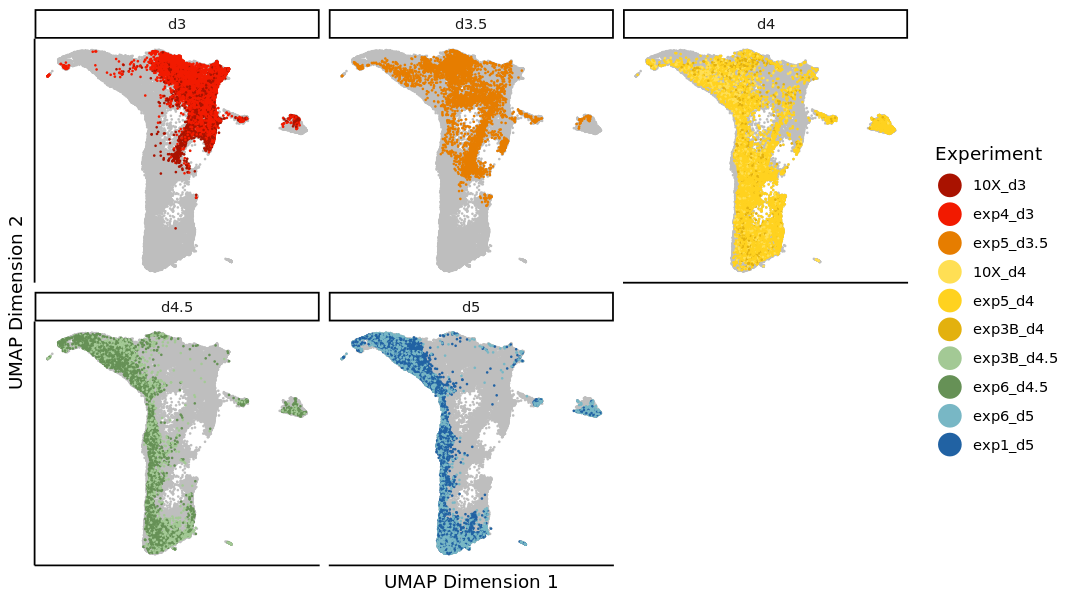

In [5]:
############################
## Supplementary Figure 1 ##
############################

## Supplementary Figure 1A
#options(repr.plot.width=10, repr.plot.height=3.5)
to.plot <- g_meta
to.plot$timepoint_exp <- paste0(unlist(lapply(strsplit(to.plot$experiment, '_'), function(s) s[[1]])), '_', to.plot$timepoint)
to.plot[timepoint_exp == 'gastr_d3', timepoint_exp := '10X_d3']
to.plot[timepoint_exp == 'gastr_d4', timepoint_exp := '10X_d4']
to.plot[experiment == 'gastr_d3', experiment := '10X_d3']
to.plot[experiment == 'gastr_d4', experiment := '10X_d4']
to.plot$timepoint_exp <- factor(to.plot$timepoint_exp, levels=names(experiment_tp_colours))
to.plot$experiment <- factor(to.plot$experiment, levels=c("10X_d3", "exp4_d3", "exp5_d3.5_d4", "10X_d4", "exp3B_d4_d4.5", "exp3C_d4_d4.5", "exp6_d4.5_d5", "exp1_d5"))
p <- ggplot(to.plot, aes(x=experiment, y=nCount_RNA, fill=batch)) +
  geom_boxplot(outlier.size = 0.1) +
  guides(fill=guide_legend(ncol=2)) +
  scale_y_continuous(trans='log2', breaks=c(1000, 10000, 100000)) +
  labs(y="UMI per cell") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/SuppFig1/A.pdf',
  plot = p,
  device = 'pdf',
  width = 10,
  height = 3.5,
  units = "in"
)

p <- ggplot(to.plot, aes(x=experiment, y=nFeature_RNA, fill=batch)) +
  geom_boxplot(outlier.size = 0.1) +
  guides(fill=guide_legend(ncol=2)) +
  labs(y="Genes per cell") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/SuppFig1/C.pdf',
  plot = p,
  device = 'pdf',
  width = 10,
  height = 3.5,
  units = "in"
)

p <- ggplot(to.plot, aes(x=experiment, y=percent.mt, fill=batch)) +
  geom_boxplot(outlier.size = 0.1) +
  guides(fill=guide_legend(ncol=2)) +
  scale_y_continuous(trans='log2') +
  labs(y="Mitochondrial percentage\nper cell") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/SuppFig1/E.pdf',
  plot = p,
  device = 'pdf',
  width = 10,
  height = 3.5,
  units = "in"
)

p <- ggplot(to.plot, aes(x=experiment, y=percent.ribo, fill=batch)) +
  geom_boxplot(outlier.size = 0.1) +
  guides(fill=guide_legend(ncol=2)) +
  scale_y_continuous(trans='log2') +
  labs(y="Ribosomal percentage\nper cell") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/SuppFig1/G.pdf',
  plot = p,
  device = 'pdf',
  width = 10,
  height = 3.5,
  units = "in"
)

options(repr.plot.width=6, repr.plot.height=3.5)
p <- ggplot(data=to.plot, mapping = aes(x=X1, y=X2, colour=nCount_RNA.normed)) +
  geom_point(size=0.1, alpha=1) +
  #ggrastr::geom_point_rast(size=0.1, alpha=1) +
  labs(x="UMAP Dimension 1", y="UMAP Dimension 2") +
  scale_colour_viridis(name = "Normalised\nUMI per cell") +
  theme_classic() +
  theme(axis.text=element_blank(),
        axis.ticks = element_blank())
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/SuppFig1/B.pdf',
  plot = p,
  device = 'pdf',
  width = 6,
  height = 3.5,
  units = "in"
)

p <- ggplot(data=to.plot, mapping = aes(x=X1, y=X2, colour=nFeature_RNA.normed)) +
  geom_point(size=0.1, alpha=1) +
  #ggrastr::geom_point_rast(size=0.1, alpha=1) +
  labs(x="UMAP Dimension 1", y="UMAP Dimension 2") +
  scale_colour_viridis(name = "Normalised\ngenes\nper cell") +
  #guides(colour = guide_legend(override.aes = list(size=6))) +
  theme_classic() +
  theme(axis.text=element_blank(),
        axis.ticks = element_blank())
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/SuppFig1/D.pdf',
  plot = p,
  device = 'pdf',
  width = 6,
  height = 3.5,
  units = "in"
)

p <- ggplot(data=to.plot, mapping = aes(x=X1, y=X2, colour=percent.mt.normed)) +
  geom_point(size=0.1, alpha=1) +
  #ggrastr::geom_point_rast(size=0.1, alpha=1) +
  labs(x="UMAP Dimension 1", y="UMAP Dimension 2") +
  scale_colour_viridis(name = "Normalised\nMitochondrial\nPercentage") +
  theme_classic() +
  theme(axis.text=element_blank(),
        axis.ticks = element_blank())
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/SuppFig1/F.pdf',
  plot = p,
  device = 'pdf',
  width = 6,
  height = 3.5,
  units = "in"
)

p <- ggplot(data=to.plot, mapping = aes(x=X1, y=X2, colour=percent.ribo.normed)) +
  geom_point(size=0.1, alpha=1) +
  #ggrastr::geom_point_rast(size=0.1, alpha=1) +
  labs(x="UMAP Dimension 1", y="UMAP Dimension 2") +
  scale_colour_viridis(name = "Normalised\nRibosomal\nPercentage") +
  theme_classic() +
  theme(axis.text=element_blank(),
        axis.ticks = element_blank())
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/SuppFig1/H.pdf',
  plot = p,
  device = 'pdf',
  width = 6,
  height = 3.5,
  units = "in"
)

options(repr.plot.width=9, repr.plot.height=5)
p <- ggplot(data=to.plot[sample(nrow(to.plot)),][timepoint %in% c("d3", "d3.5", "d4", "d4.5", "d5")], mapping = aes(x=X1, y=X2, colour=timepoint_exp)) +
  geom_point(data=select(to.plot,-timepoint), colour="grey", size=0.1, alpha=1) +
  geom_point(size=0.1, alpha=1) +
  #ggrastr::geom_point_rast(data=select(to.plot,-timepoint), colour="grey", size=0.1, alpha=1) +
  #ggrastr::geom_point_rast(size=0.1, alpha=1) +
  labs(x="UMAP Dimension 1", y="UMAP Dimension 2") +
  scale_colour_manual(values = experiment_tp_colours, name = "Experiment") +
  guides(colour = guide_legend(override.aes = list(size=6))) +
  theme_classic() +
  theme(axis.text=element_blank(),
        axis.ticks = element_blank()) +
  facet_wrap(~ timepoint, nrow=2)
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/SuppFig1/I.pdf',
  plot = p,
  device = 'pdf',
  width = 9,
  height = 5,
  units = "in"
)

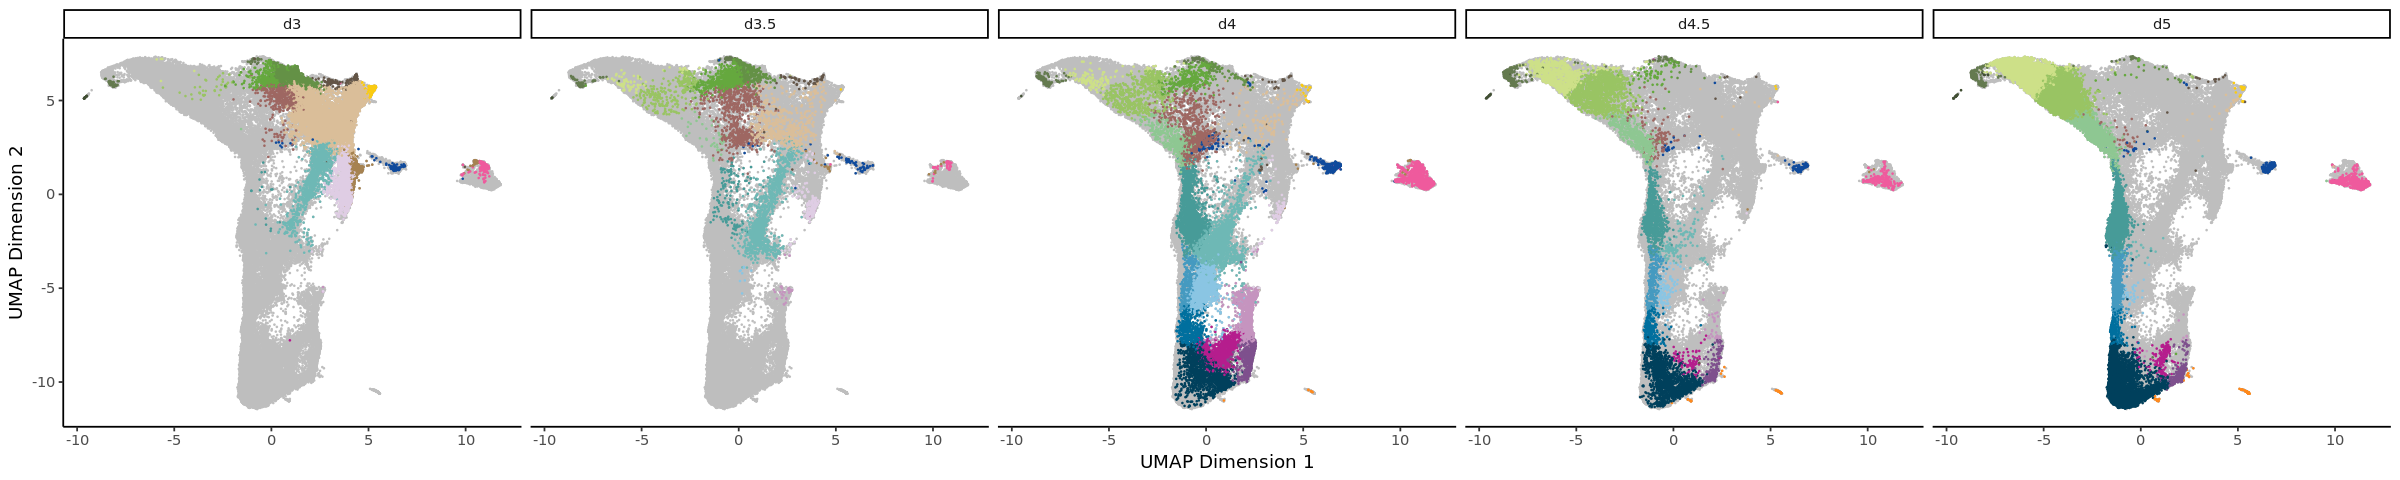

In [6]:
############################
## Supplementary Figure 3 ##
############################

## Supplementary Figure 3B
options(repr.plot.width=20, repr.plot.height=4)
p <- ggplot(data=g_meta[timepoint %in% c("d3", "d3.5", "d4", "d4.5", "d5")], mapping = aes(x=X1, y=X2, colour=cluster)) +
  geom_point(data=select(g_meta,-timepoint), colour="grey", size=0.1, alpha=1) +
  geom_point(size=0.1, alpha=1) +
  #ggrastr::geom_point_rast(data=select(g_meta,-timepoint), colour="grey", size=0.1, alpha=1) +
  #ggrastr::geom_point_rast(size=0.1, alpha=1) +
  labs(x="UMAP Dimension 1", y="UMAP Dimension 2") +
  scale_colour_manual(values = cluster_colours, name = "Cell Type") +
  guides(colour = guide_legend(override.aes = list(size=6))) +
  theme_classic() +
  theme(legend.position = 'None') +
  facet_wrap(~ timepoint, nrow=1)
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/SuppFig3/B.pdf',
  plot = p,
  device = 'pdf',
  width = 20,
  height = 4,
  units = "in"
)

Using 'N' as value column. Use 'value.var' to override



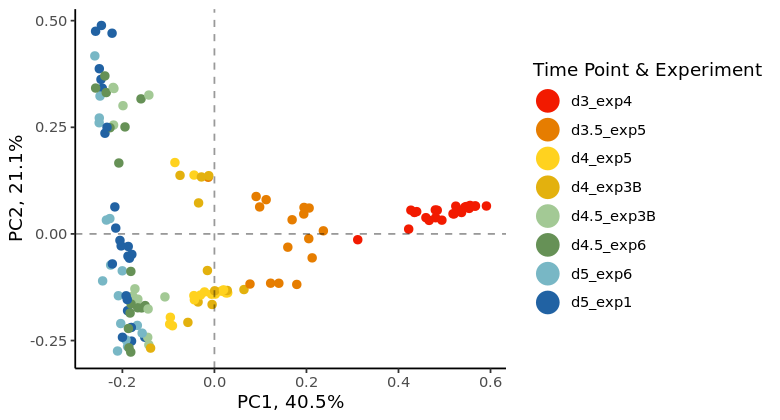

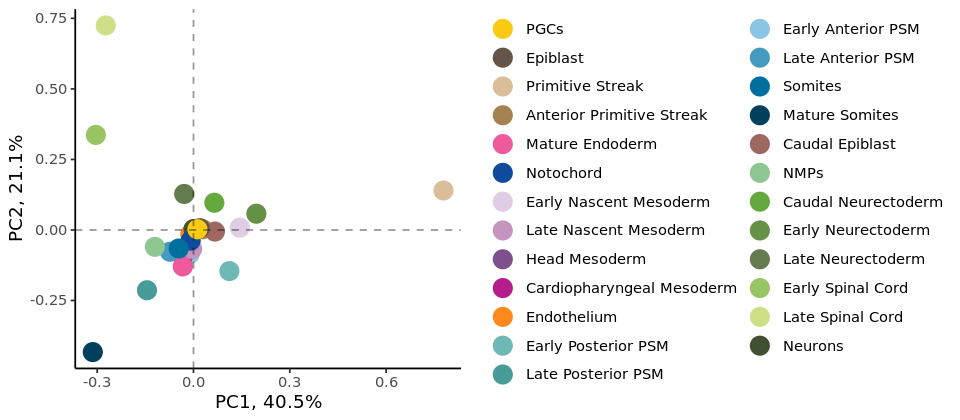

tp=d3

Using 'N' as value column. Use 'value.var' to override

tp=d4

Using 'N' as value column. Use 'value.var' to override

tp=d5

Using 'N' as value column. Use 'value.var' to override

tp=d4.5

Using 'N' as value column. Use 'value.var' to override

tp=d3.5

Using 'N' as value column. Use 'value.var' to override

Warning message:
“Removed 3 row(s) containing missing values (geom_path).”


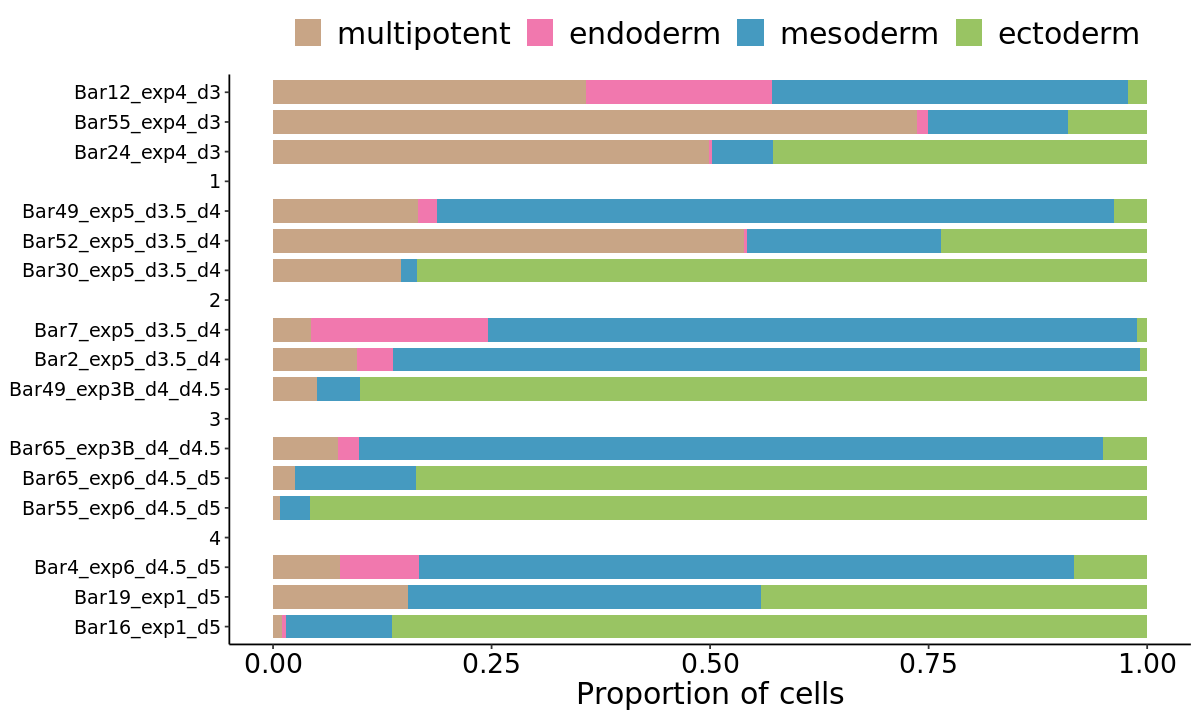

In [7]:
##############
## Figure 2 ##
##############

## Figure 2B
to.plot <- g_meta[(!is.na(cluster)) &(!is.na(MULTI_class)) & (MULTI_class!="Doublet") & (MULTI_class!="Negative") & (MULTI_class!="unidentifiable")][,.N,by=c("cluster","MULTI_class")]
toplot_dcast <- dcast(to.plot, cluster ~ MULTI_class)
toplot_dcast <- as.matrix(toplot_dcast, rownames="cluster")
toplot_dcast[is.na(toplot_dcast)] = 0
toplot_dcast <- t(t(toplot_dcast)/colSums(toplot_dcast))
ct_pca <- prcomp(t(as.matrix(toplot_dcast)), scale = FALSE)
gastruloid_pca <- data.table(ct_pca$x)
gastruloid_pca$MULTI_class <- colnames(toplot_dcast)
PC1_var <- round(((ct_pca[[1]]**2)/sum(ct_pca[[1]]**2))[[1]],3)*100
PC2_var <- round(((ct_pca[[1]]**2)/sum(ct_pca[[1]]**2))[[2]],3)*100
tmp <- g_meta[,.N,by=c("MULTI_class", "timepoint", "experiment")]
to.plot <- merge(gastruloid_pca, tmp, by="MULTI_class", all.x=TRUE)
options(repr.plot.width=6.5, repr.plot.height=3.5)
to.plot$timepoint_exp <- factor(paste0(to.plot$timepoint, '_', unlist(lapply(strsplit(to.plot$experiment, '_'), function(s) s[[1]]))), levels=names(tp_experiment_colours))
p <- ggplot(to.plot, aes(x=PC1, y=PC2, colour=timepoint_exp)) +
  geom_point(size=2) +
  labs(x=paste0("PC1, ",PC1_var,"%"),
       y=paste0("PC2, ",PC2_var,"%")) +
  geom_vline(xintercept = 0, linetype="dashed", alpha=0.4) +
  geom_hline(yintercept = 0, linetype="dashed", alpha=0.4) +
  scale_colour_manual(values = tp_experiment_colours[names(tp_experiment_colours) %in% unique(to.plot$timepoint_exp)], name = "Time Point & Experiment") +
  theme_classic() +
  guides(colour = guide_legend(override.aes = list(size=6)))
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/Fig2/B.pdf',
  plot = p,
  device = 'pdf',
  width = 6.5,
  height = 3.5,
  units = "in"
)

## Figure 2C
options(repr.plot.width=8, repr.plot.height=3.5)
PC_loadings <- as.data.table(ct_pca$rotation)
PC_loadings$cluster <- factor(rownames(ct_pca$rotation), levels=cluster_order)
p <- ggplot(PC_loadings, aes(x=PC1, y=PC2, colour=cluster)) +
  geom_point(size=5) +
  geom_vline(xintercept = 0, linetype="dashed", alpha=0.4) +
  geom_hline(yintercept = 0, linetype="dashed", alpha=0.4) +
  scale_colour_manual(values = cluster_colours[cluster_order], name = "") +
  labs(x=paste0("PC1, ",PC1_var,"%"),
       y=paste0("PC2, ",PC2_var,"%")) +
  theme_classic()
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/Fig2/C.pdf',
  plot = p,
  device = 'pdf',
  width = 8,
  height = 3.5,
  units = "in"
)

## Figure 2D
bar_selecs <- c("Bar12_exp4_d3", "Bar55_exp4_d3", "Bar24_exp4_d3", #d3
                 "1",
                 "Bar49_exp5_d3.5_d4", "Bar52_exp5_d3.5_d4", "Bar30_exp5_d3.5_d4", # d3.5
                 "2",
                 "Bar7_exp5_d3.5_d4", "Bar2_exp5_d3.5_d4", "Bar49_exp3B_d4_d4.5", # d4
                 "3",
                 "Bar65_exp3B_d4_d4.5",  "Bar65_exp6_d4.5_d5", "Bar55_exp6_d4.5_d5", # d4.5
                 "4",
                 "Bar4_exp6_d4.5_d5" , "Bar19_exp1_d5", "Bar16_exp1_d5"# d5
)
to.plot <- g_meta[(MULTI_class %in% bar_selecs) & (cluster %in% cluster_order),.N,by=c("cluster","MULTI_class")]
to.plot$cluster <- unlist(lapply(to.plot$cluster, function(c) inv_cluster_grouping[[c]]))
to.plot$MULTI_class = factor(to.plot$MULTI_class, levels=rev(bar_selecs))
to.plot$cluster = factor(to.plot$cluster, levels=rev(group_order))
options(repr.plot.width=10, repr.plot.height=6)
p <- ggplot(to.plot, aes_string(x="MULTI_class", y="N", fill="cluster")) +
  scale_x_discrete(drop=FALSE) + 
  labs(y="Proportion of cells") +
  theme_classic() +
  scale_fill_manual(values = group_colours[group_order], name = "") +
  theme(
    strip.background = element_blank(),
    strip.text = element_text(color="black", size=rel(1.3)),
    axis.title.x = element_text(color="black", size=18),
    axis.title.y = element_blank(),
    axis.text.y = element_text(size=rel(1.3), color="black"),
    axis.text.x = element_text(size=16, color="black"),
    legend.position="top",
    legend.title = element_text(size=18),
    legend.text = element_text(size=18)
  ) +
  geom_bar(stat="identity", position="fill", width = 0.8) +
  coord_flip()
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/Fig2/D.pdf',
  plot = p,
  device = 'pdf',
  width = 10,
  height = 6,
  units = "in"
)

## Figure 2E
calc_multinomial_ll <- function(n_cg) {
  p_c <- rowSums(n_cg)/sum(n_cg)
  logp_c <- log(p_c)
  n_g <- colSums(n_cg)
  return(list(ll=sum(lfactorial(n_g)) - sum(lfactorial(n_cg)) + sum(n_cg * logp_c), k=length(p_c)))
}
calc_k_multinomial_ll <- function(toplot_dcast, km) {
  ll <- 0
  k <- 0
  for (clu in unique(km)) {
    cols <- names(km)[km==clu]
    out <- calc_multinomial_ll(toplot_dcast[,..cols])
    ll <- ll + out$ll
    k <- k + out$k
  }
  return(list(ll=ll, k=k))
}
calc_AICc <- function(ll, k, n) {
  if (k >= n) {
    return(NA)
  } else {
    return(2*k - 2*ll + (((2*(k^2)) + (2*k)) / (n - k - 1)))
  }
}
MULTI_timepoints <- unique(g_meta$timepoint)
MULTI_timepoints <- MULTI_timepoints[!(MULTI_timepoints %in% c("d3_d3.5", "d3.5_d4", "d4_d4.5", "d4.5_d5"))]
AICc_list <- list()
for (tp in MULTI_timepoints) {
  message('tp=', tp)
  to.plot <- g_meta[(timepoint==tp) & (!is.na(cluster) & (cluster != "unlabelled")) & (!is.na(MULTI_class)) & (MULTI_class!="Doublet") & (MULTI_class!="Negative") & (MULTI_class!="unidentifiable")]
  to.plot[cluster %in% cluster_grouping$mesoderm, rough_clusters := 'Mesodermal']
  to.plot[cluster %in% cluster_grouping$ectoderm, rough_clusters := 'Neural']
  to.plot <- to.plot[rough_clusters %in% c('Mesodermal', 'Neural'),.N,by=c("rough_clusters","MULTI_class")]
  toplot_dcast <- dcast(to.plot, rough_clusters ~ MULTI_class, fun.aggregate=sum)
  AICc_list[[tp]] <- list()
  # H0: Only one cluster
  cols <- unique(to.plot$MULTI_class)
  k1 <- calc_multinomial_ll(toplot_dcast[,..cols])
  AICc_list[[tp]][[1]] <- calc_AICc(k1$ll, k1$k, length(cols))
  for (i in 2:10) {
    km_tmp <- kmeans(((t(toplot_dcast[,..cols])/rowSums(t(toplot_dcast[,..cols])))[,1]), i, nstart=5)$cluster
    out <- calc_k_multinomial_ll(toplot_dcast, km_tmp)
    AICc_list[[tp]][[i]] <- calc_AICc(out$ll, out$k, length(km_tmp))
  }
  
}
options(repr.plot.width=4, repr.plot.height=3)
to.plot <- as.data.table(AICc_list)[, lapply(.SD, as.numeric)]
to.plot$i <- 1:nrow(to.plot)
to.plot <- melt(to.plot, id.vars = "i")
to.plot$variable <- factor(to.plot$variable, levels = c("d3", "d3.5", "d4", "d4.5", "d5"))
p <- ggplot(data=to.plot, aes(x=i, y=value, colour=variable)) +
  geom_line() +
  labs(x="Number of Clusters", y="AICc") +
  guides(colour = guide_legend(title="Time Point")) +
  scale_colour_manual(values = timepoint_colours[names(timepoint_colours) %in% c("d3", "d3.5", "d4", "d4.5", "d5")], name = "Time Point") +
  scale_x_continuous(breaks=1:10) +
  theme_classic() +
  guides(colour = guide_legend(override.aes = list(size=2)))
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/Fig2/E.pdf',
  plot = p,
  device = 'pdf',
  width = 4,
  height = 3,
  units = "in"
)

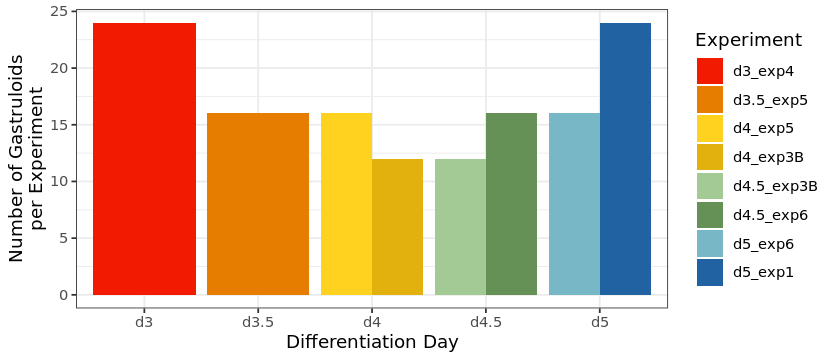

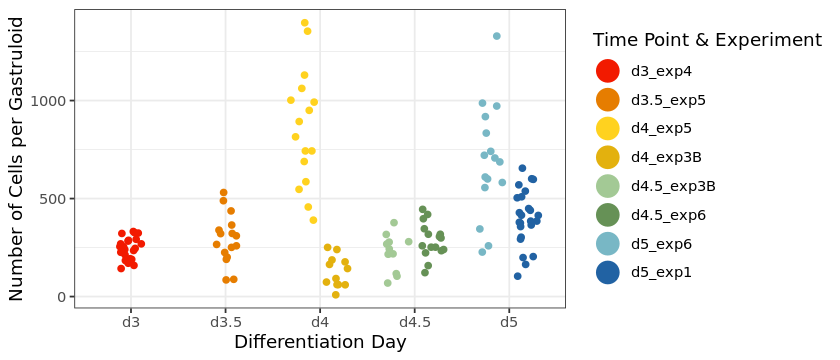

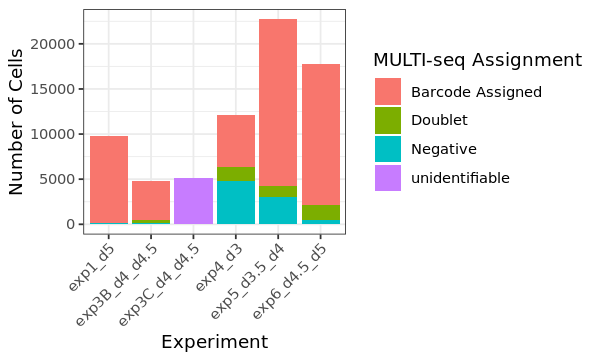

In [8]:
############################
## Supplementary Figure 4 ##
############################

## Supplementary Figure 4A
to.plot <- g_meta[!(MULTI_class %in% c("Doublet", "Negative", "unidentifiable")),.N,by=c("MULTI_class", "timepoint", "experiment")][,.N,by=c("timepoint", "experiment")]
to.plot$timepoint_exp <- factor(paste0(to.plot$timepoint, '_', unlist(lapply(strsplit(to.plot$experiment, '_'), function(s) s[[1]]))), levels=names(tp_experiment_colours))
to.plot$timepoint <- factor(to.plot$timepoint, levels=timepoint_order)
options(repr.plot.width=7, repr.plot.height=3)
p <- ggplot(to.plot, aes(x=timepoint, y=N, fill=timepoint_exp)) +
  geom_bar(stat="identity", position = position_dodge()) +
  scale_fill_manual(values = tp_experiment_colours[names(tp_experiment_colours) %in% unique(to.plot$timepoint_exp)], name = "Experiment") +
  labs(x="Differentiation Day", y="Number of Gastruloids\nper Experiment") +
  theme_bw()
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/SuppFig4/A.pdf',
  plot = p,
  device = 'pdf',
  width = 7,
  height = 3,
  units = "in"
)

## Supplementary Figure 4B
to.plot <- g_meta[!(MULTI_class %in% c("Doublet", "Negative", "unidentifiable")),.N,by=c("MULTI_class", "timepoint", "experiment")]
to.plot$timepoint_exp <- factor(paste0(to.plot$timepoint, '_', unlist(lapply(strsplit(to.plot$experiment, '_'), function(s) s[[1]]))), levels=names(tp_experiment_colours))
to.plot$timepoint <- factor(to.plot$timepoint, levels=timepoint_order)
options(repr.plot.width=7, repr.plot.height=3)
p <- ggplot(to.plot, aes(x=timepoint, y=N)) +
  geom_point(aes(colour = timepoint_exp),
             position = position_jitterdodge(jitter.width = 1.5)) +
  guides(colour = guide_legend(override.aes = list(size=6))) +
  scale_colour_manual(values = tp_experiment_colours[names(tp_experiment_colours) %in% unique(to.plot$timepoint_exp)], name = "Time Point & Experiment") +
  labs(x="Differentiation Day", y="Number of Cells per Gastruloid") +
  theme_bw()
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/SuppFig4/B.pdf',
  plot = p,
  device = 'pdf',
  width = 7,
  height = 3,
  units = "in"
)

## Supplementary Figure 4C
to.plot <- copy(g_meta)
to.plot[!(MULTI_class %in% c("Doublet", "Negative", "unidentifiable")), MULTI_class := 'Barcode Assigned']
to.plot <- to.plot[tech == "MULTI",.N,by=c("MULTI_class", "experiment")]
options(repr.plot.width=5, repr.plot.height=3)
p <- ggplot(to.plot, aes(x=experiment, y=N, fill=MULTI_class)) +
  geom_bar(stat="identity") +
  labs(x="Experiment", y="Number of Cells", fill="MULTI-seq Assignment") +
  theme_bw()  +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/SuppFig4/C.pdf',
  plot = p,
  device = 'pdf',
  width = 5,
  height = 3,
  units = "in"
)

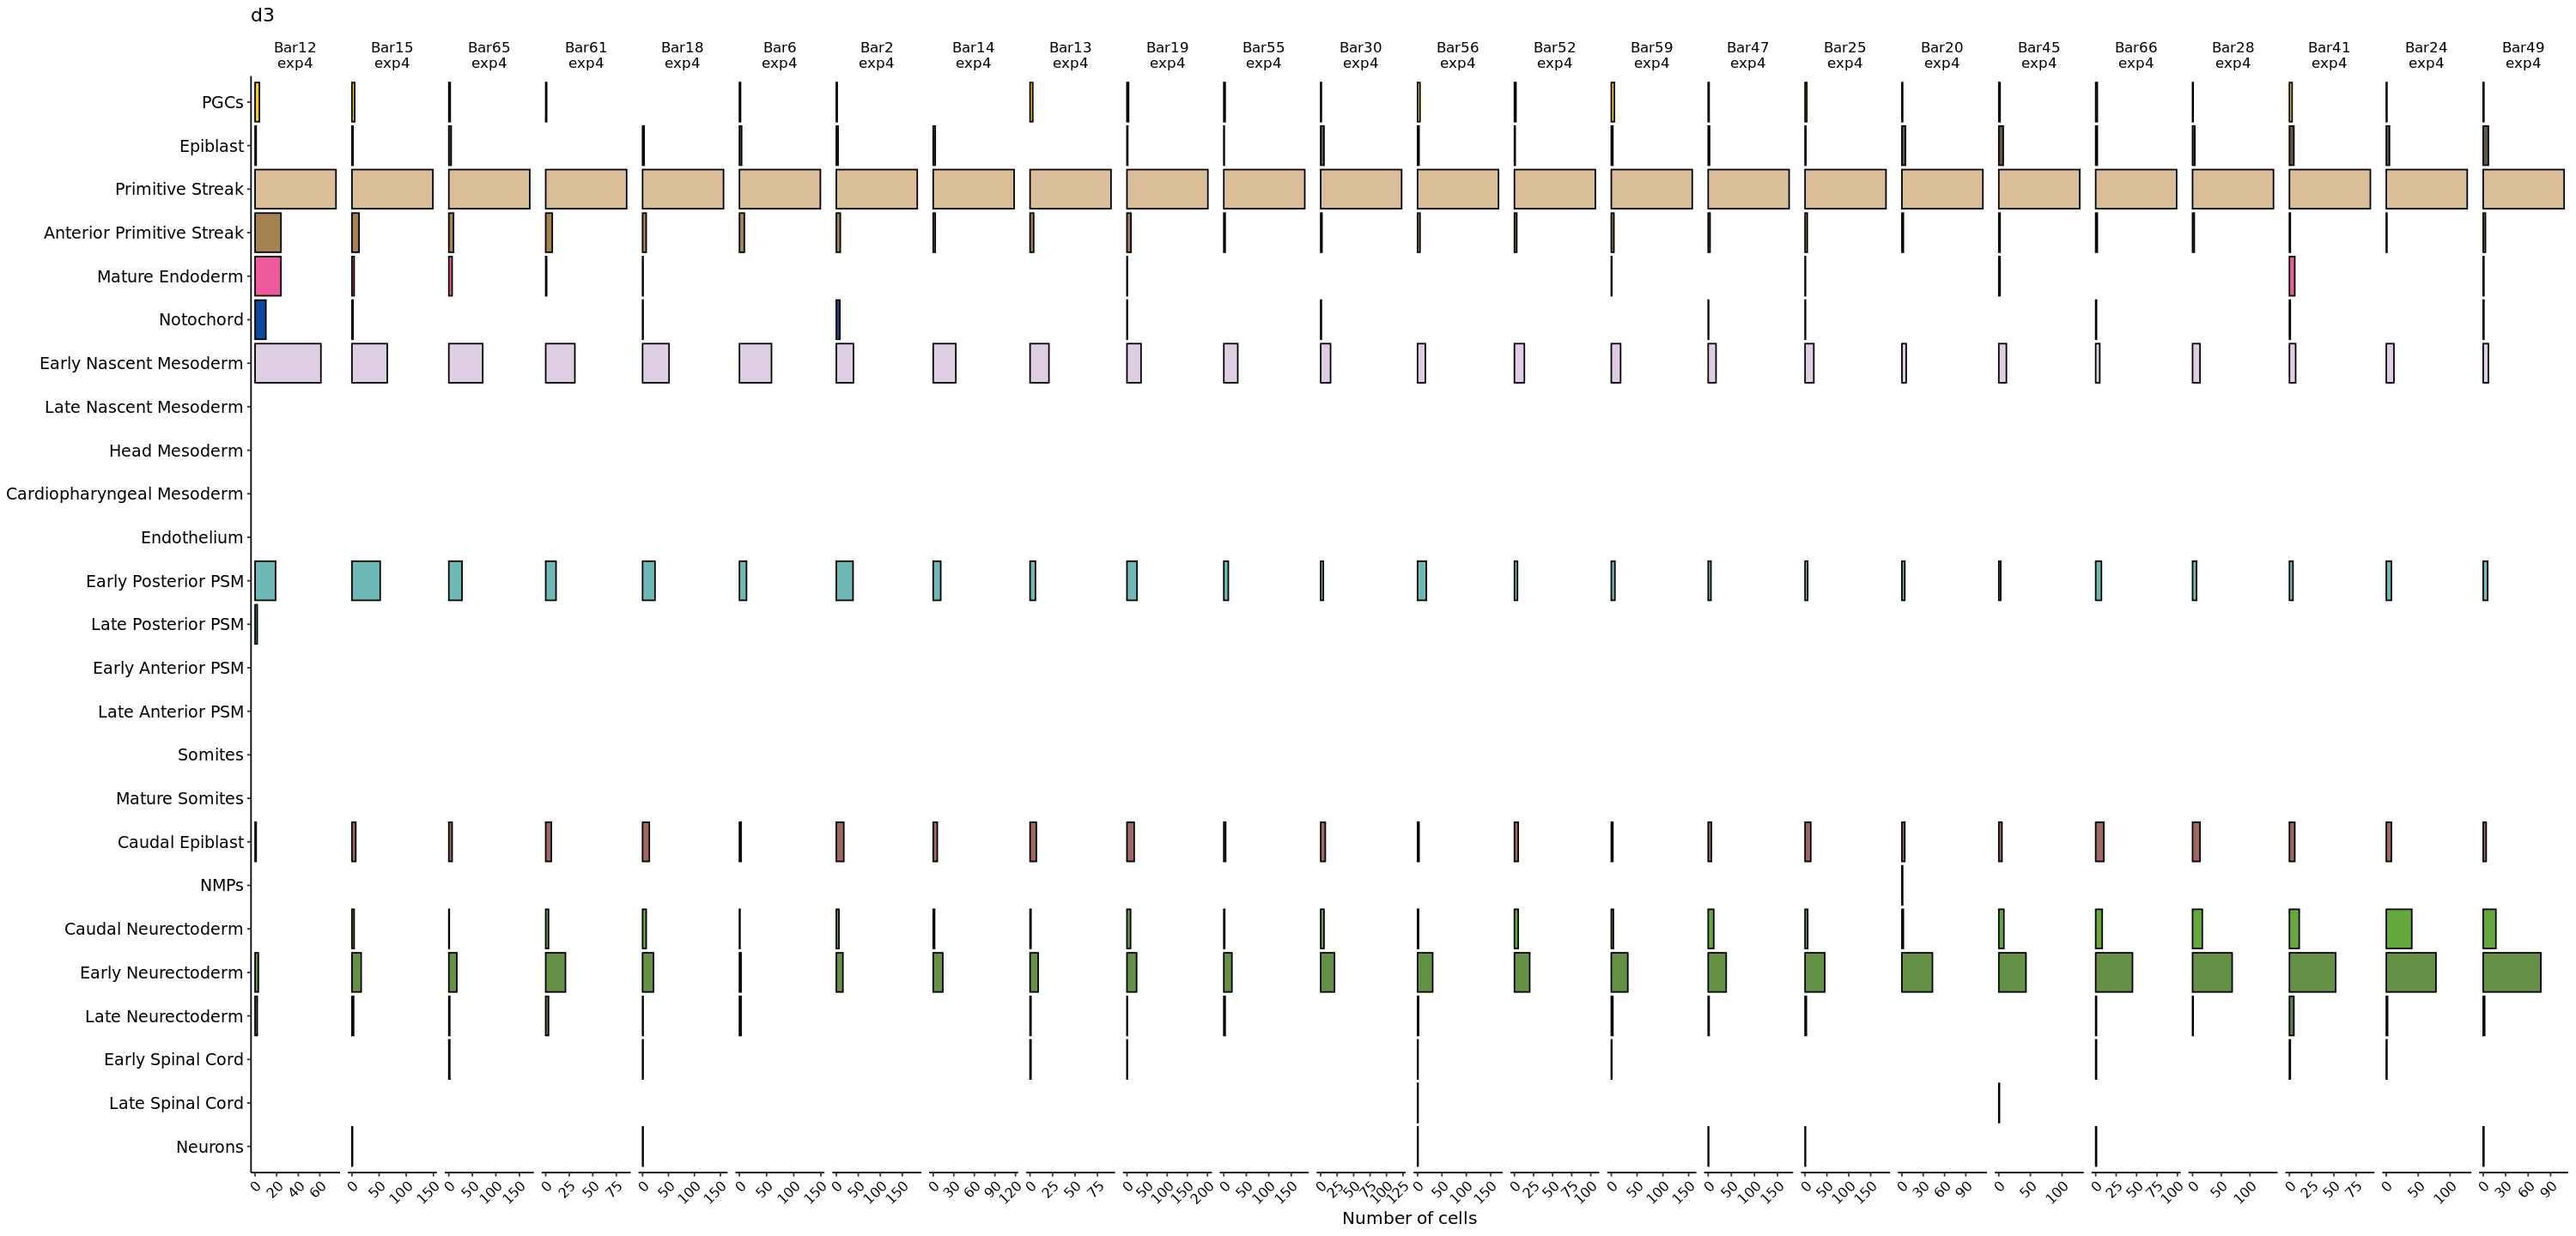

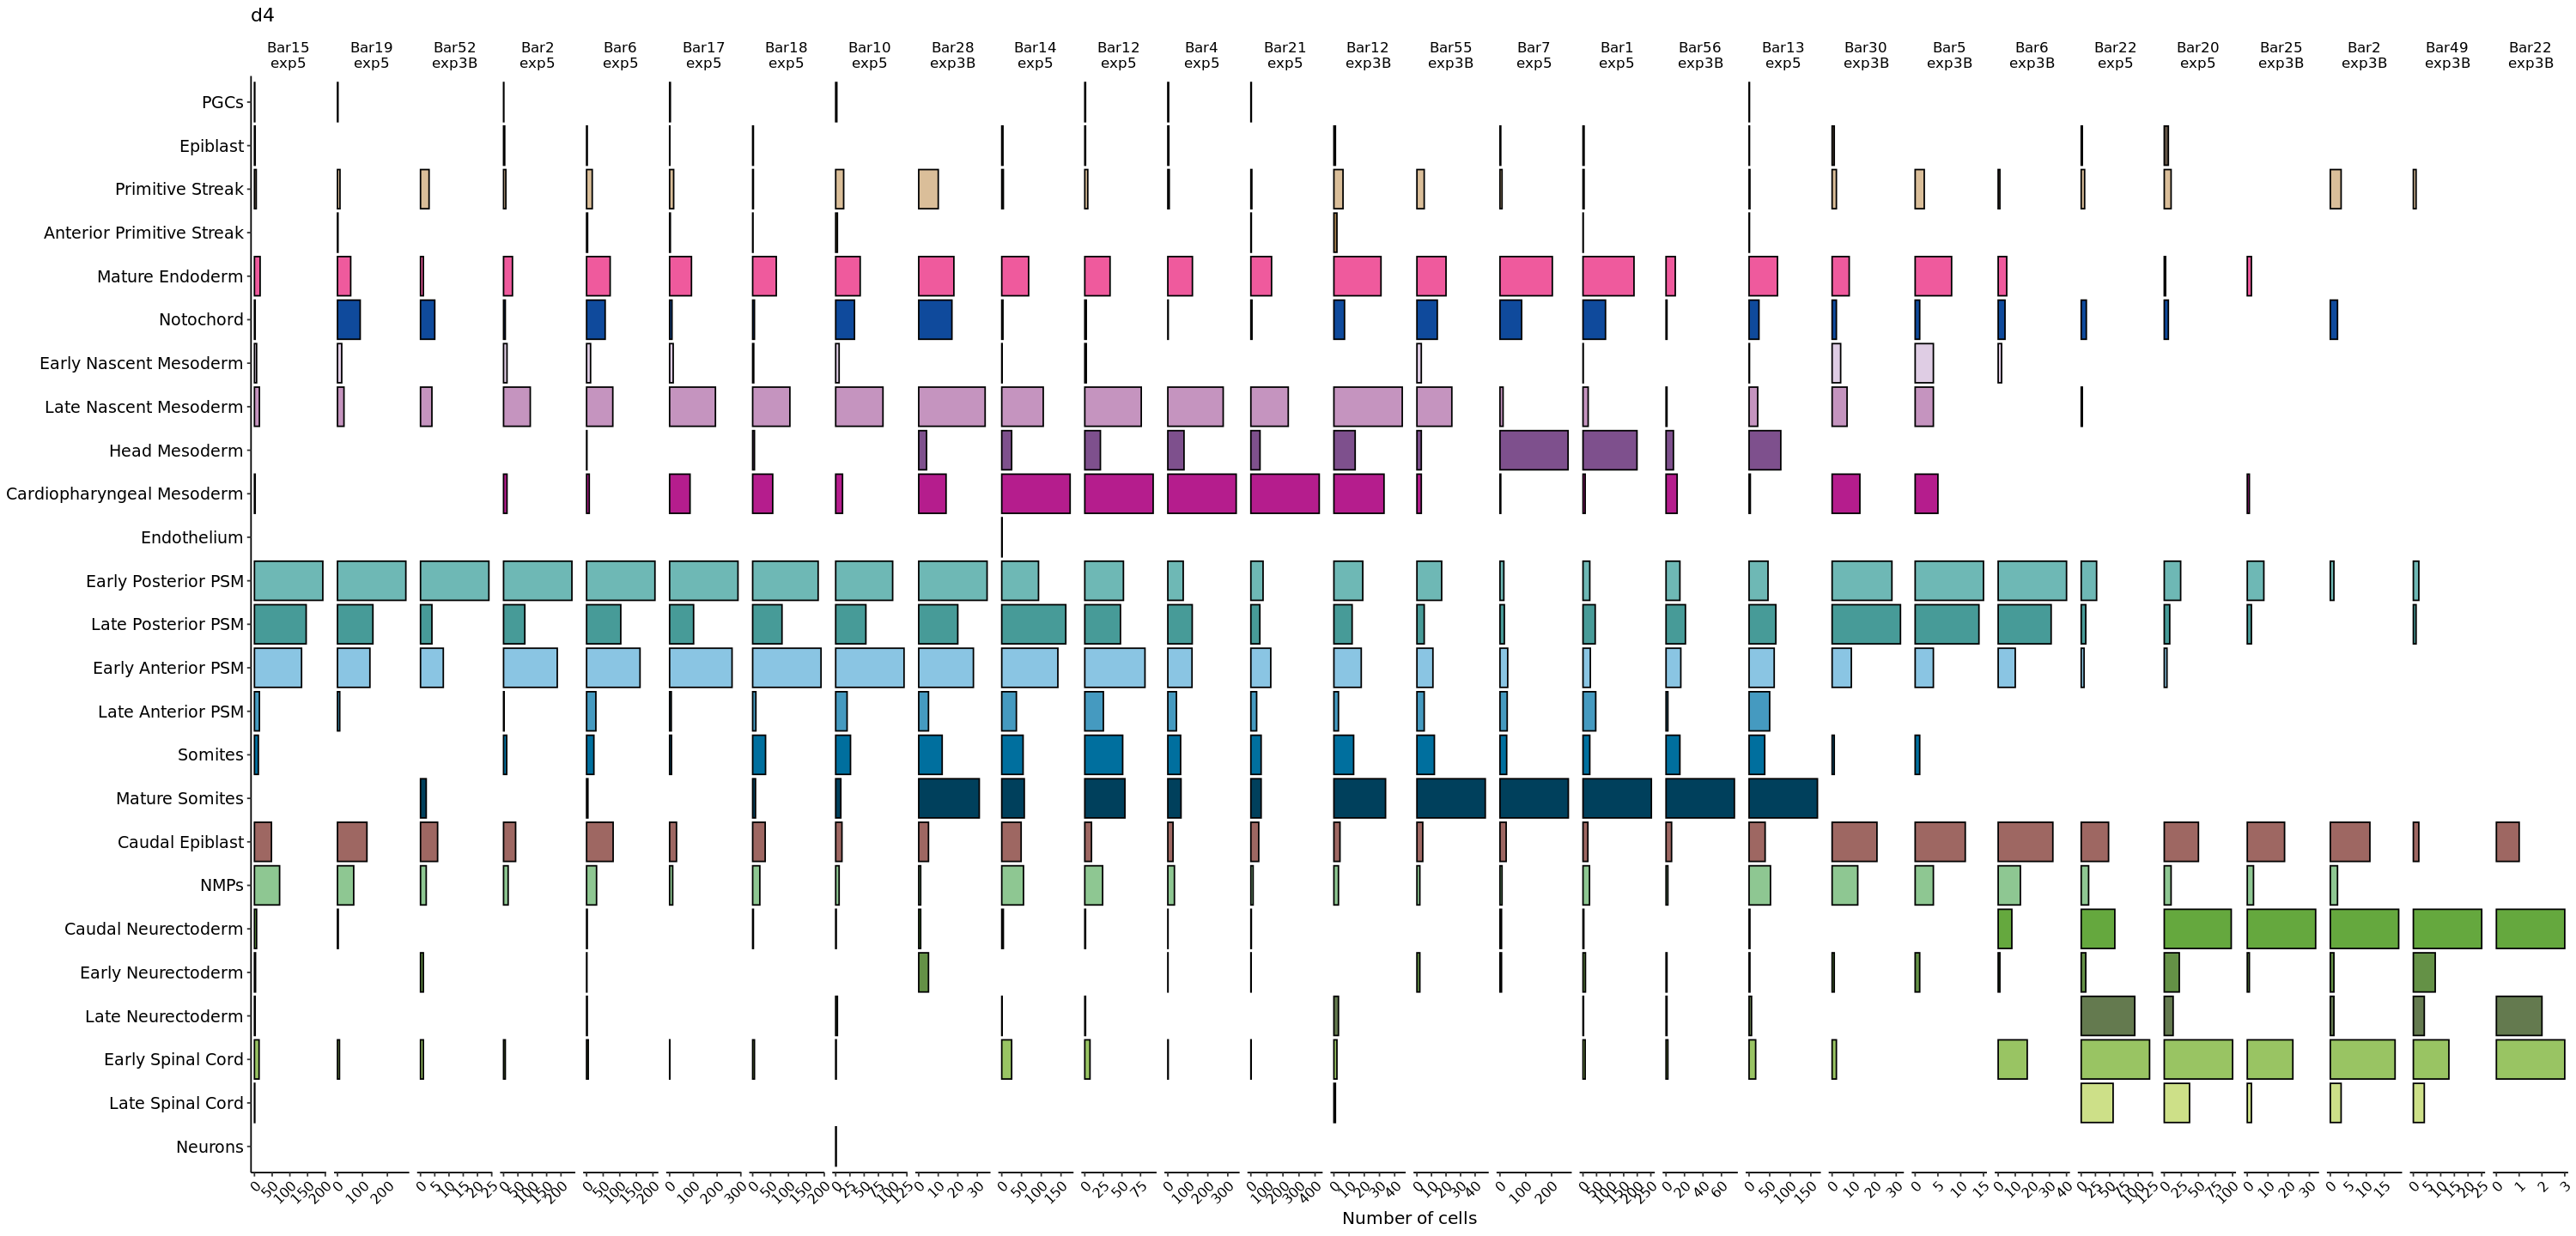

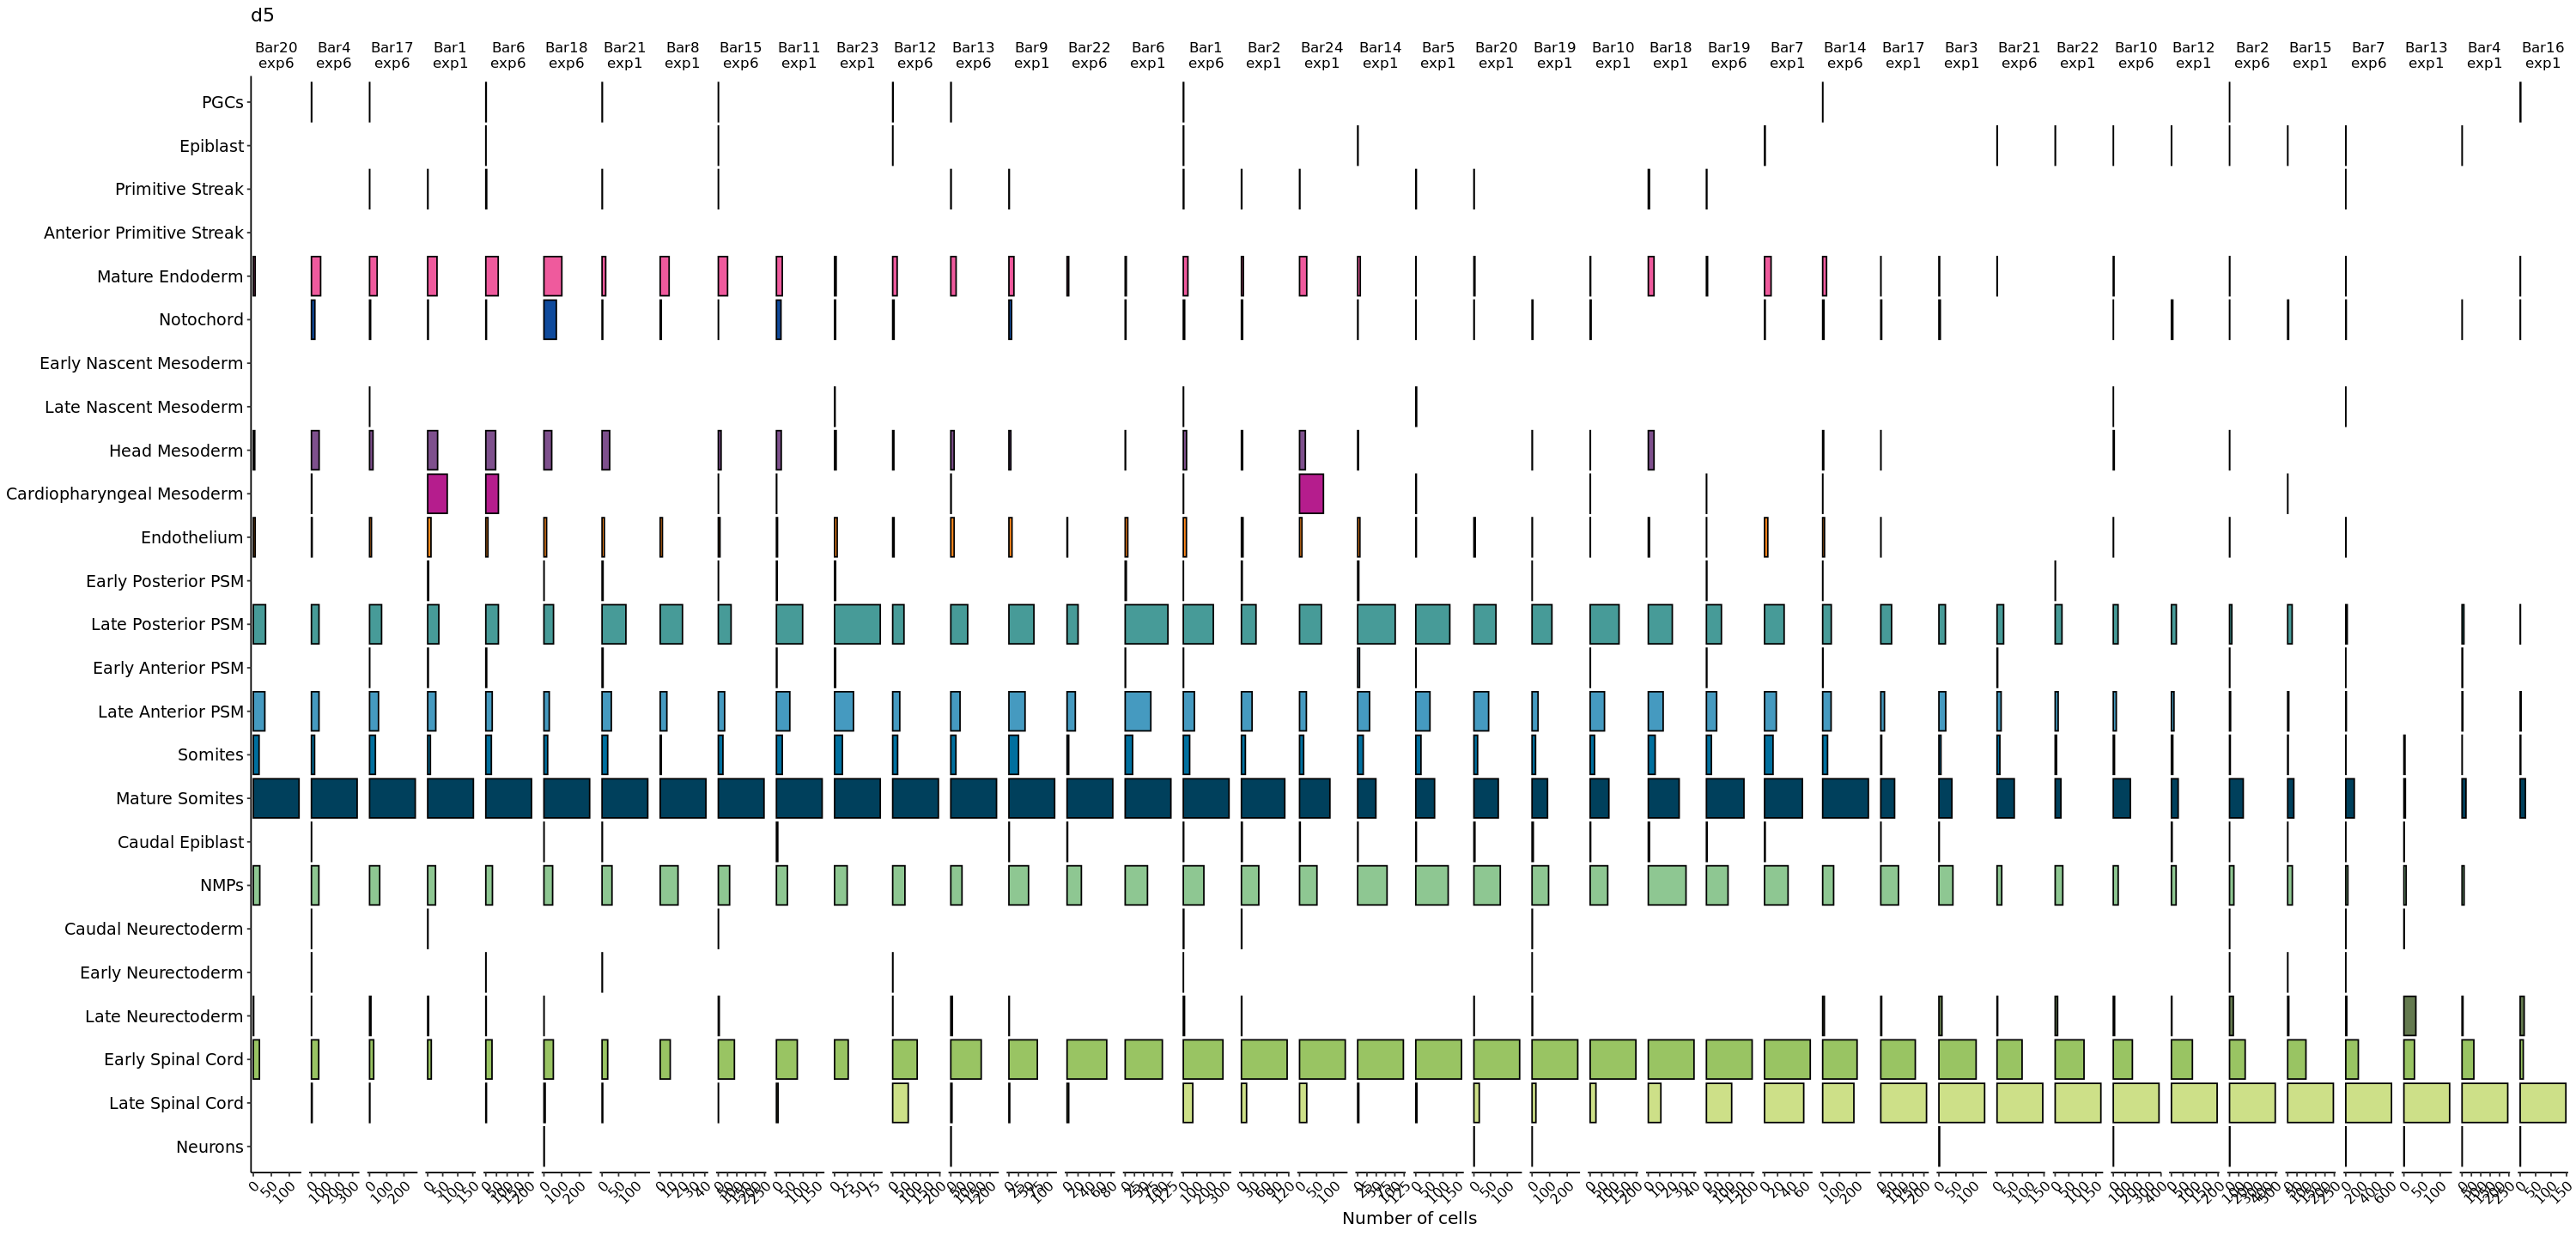

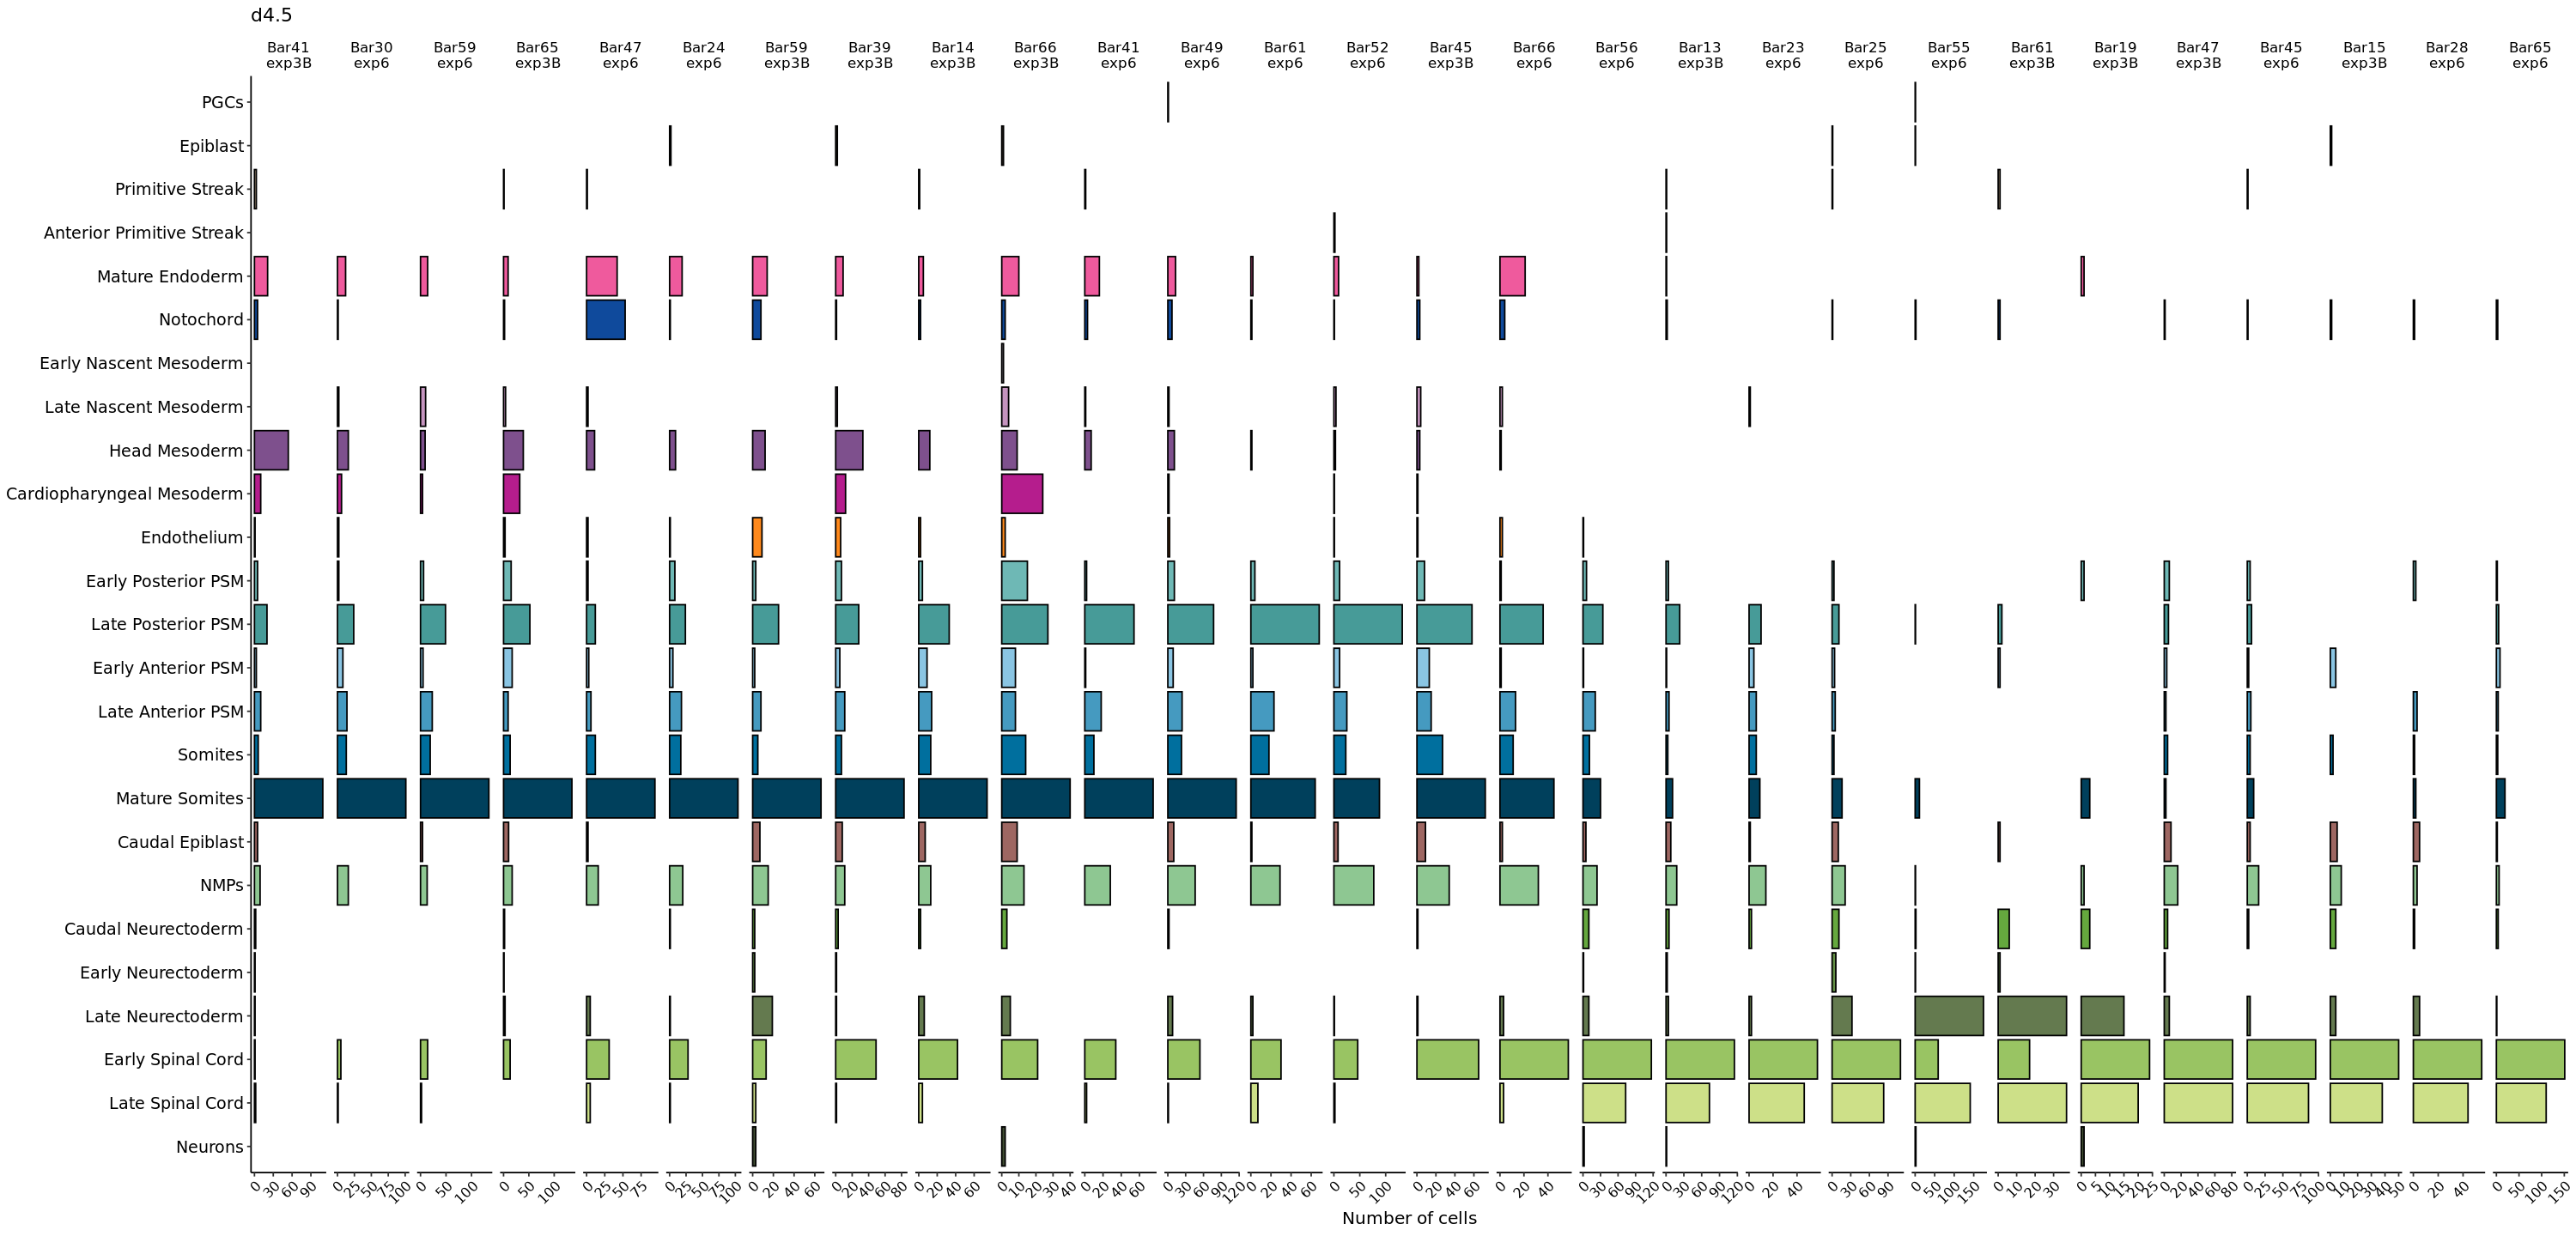

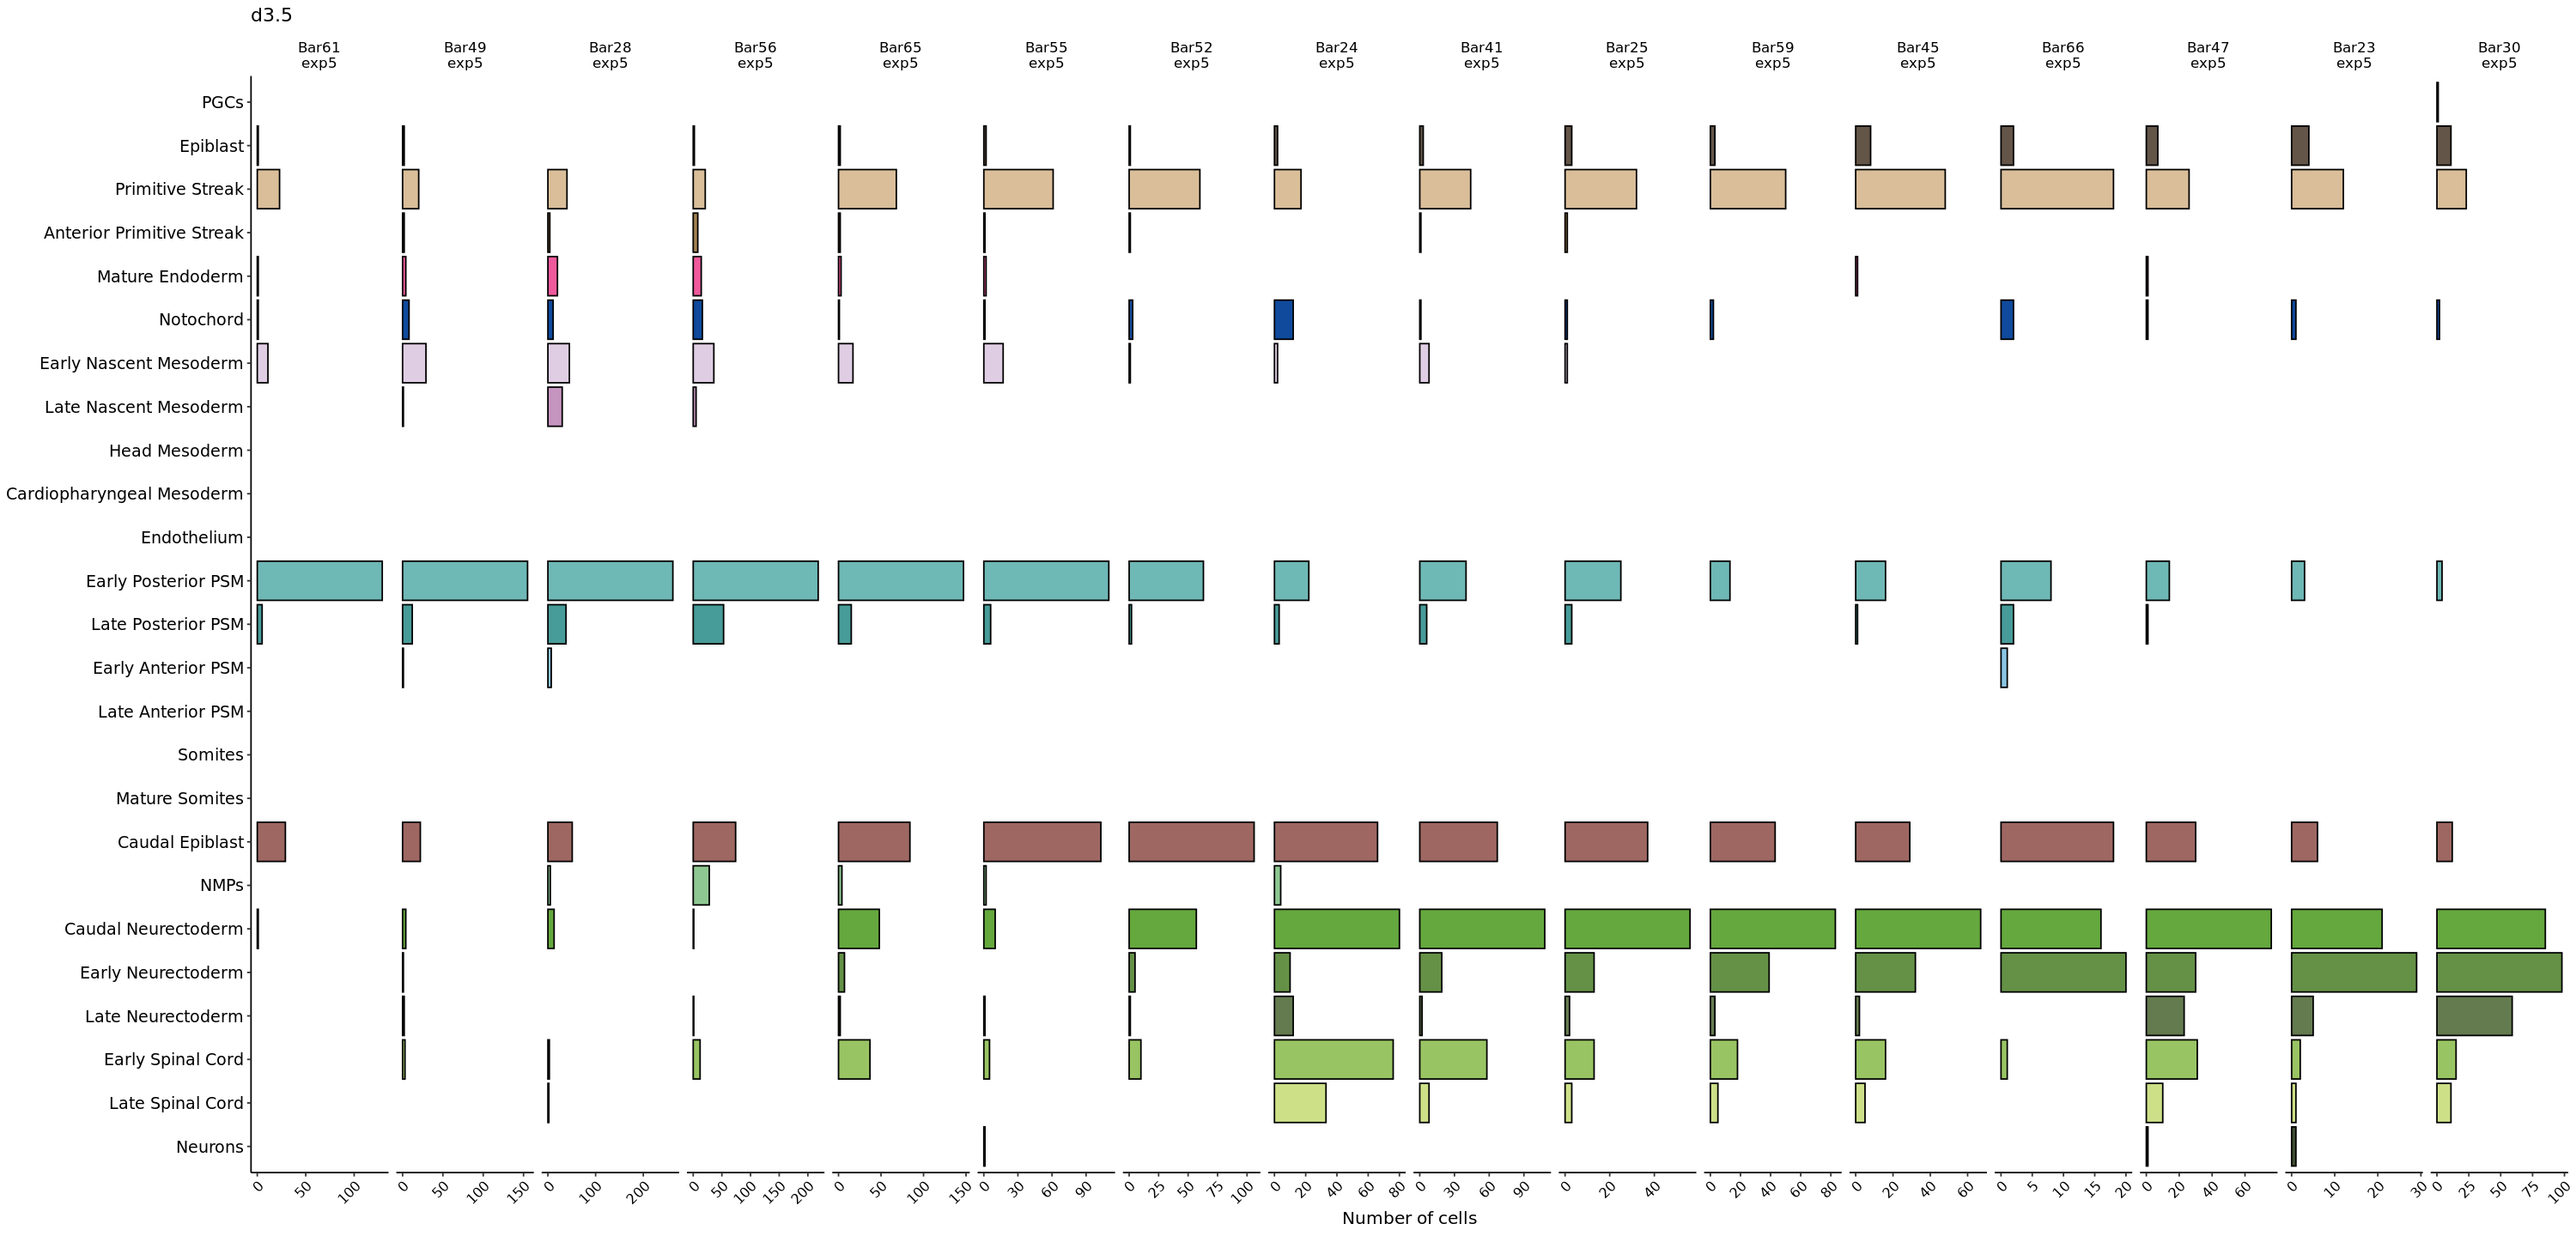

In [9]:
############################
## Supplementary Figure 5 ##
############################

options(repr.plot.width=25, repr.plot.height=12)
my_lookup <- lapply(unique(g_meta$MULTI_class), function(mc) strsplit(str_replace(mc, "_", "\n"), "_")[[1]][1])
names(my_lookup) <- unique(g_meta$MULTI_class)
my_labeller <- as_labeller(as.vector(my_lookup))
for (tp in MULTI_timepoints) {
  to.plot <- g_meta[(timepoint==tp) & (MULTI_class %in% gastruloid_order[[tp]]) & (cluster != "unlabelled"),.N,by=c("cluster","MULTI_class")]
  to.plot$MULTI_class_label <- lapply(to.plot$MULTI_class, function(mc) strsplit(str_replace(mc, "_", "\n"), "_")[[1]][1]) %>% unlist
  MULTI_class_label_order <- lapply(gastruloid_order[[tp]], function(mc) strsplit(str_replace(mc, "_", "\n"), "_")[[1]][1]) %>% unlist
  to.plot$MULTI_class_label <- factor(to.plot$MULTI_class_label, levels=rev(MULTI_class_label_order))
  to.plot$cluster = factor(to.plot$cluster, levels=rev(cluster_order))
  p <- barplot.pub(to.plot, x="cluster", colors=cluster_colours) +
    facet_wrap(~MULTI_class_label, nrow=1, scales="free_x"
    ) +
    ggtitle(tp) +
    theme(strip.text.x = element_text(size = 10)) +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
  print(p)
  ggsave(
    paste0('/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/SuppFig5/', tp, '.pdf'),
    plot = p,
    device = 'pdf',
    width = 25,
    height = 6,
    units = "in"
  )
}

Using 'N' as value column. Use 'value.var' to override

Using 'N' as value column. Use 'value.var' to override

Using 'N' as value column. Use 'value.var' to override

Using 'N' as value column. Use 'value.var' to override

Using 'N' as value column. Use 'value.var' to override



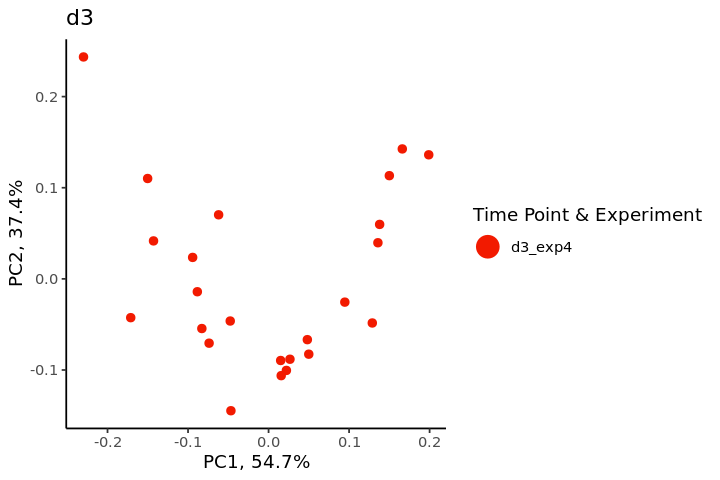

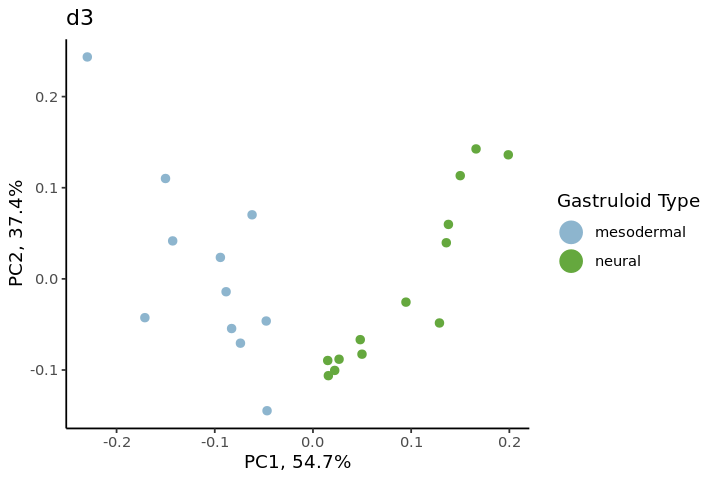

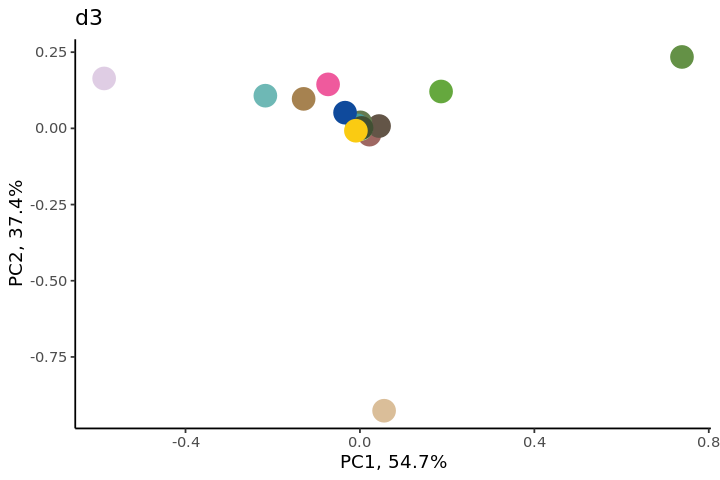

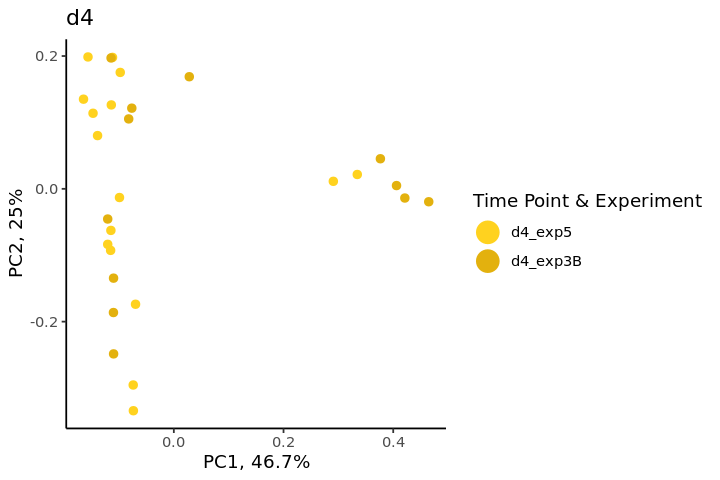

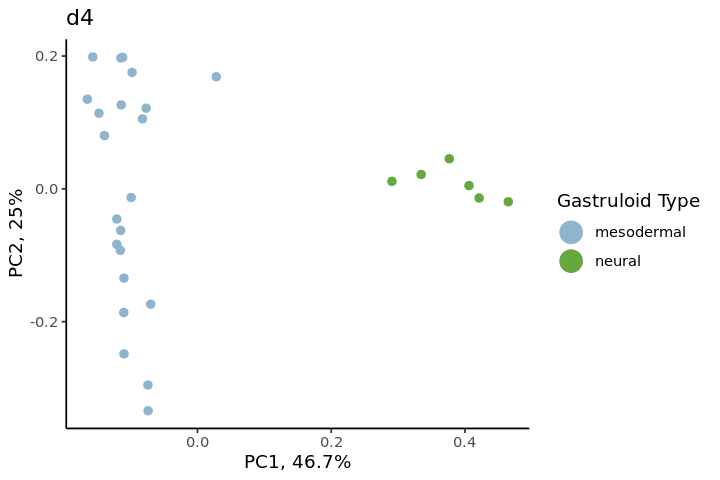

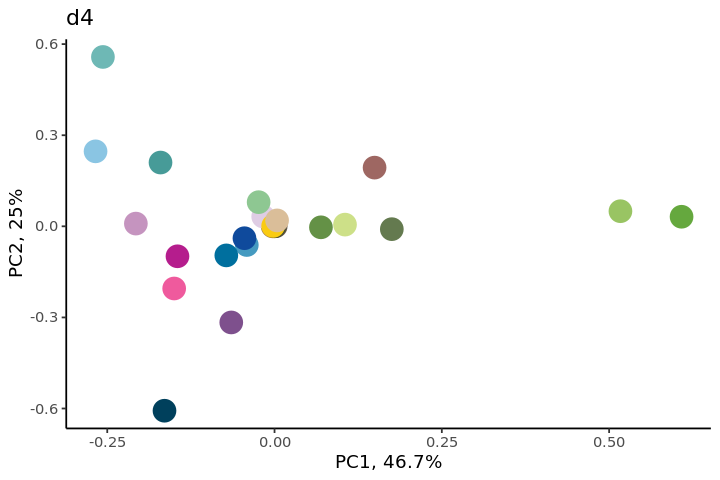

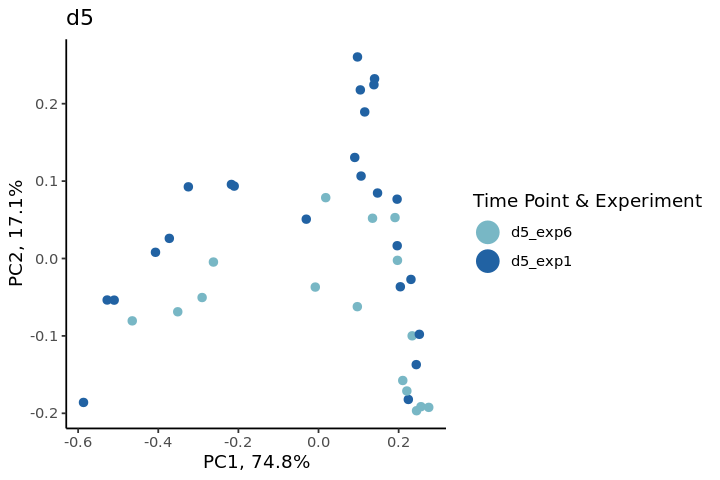

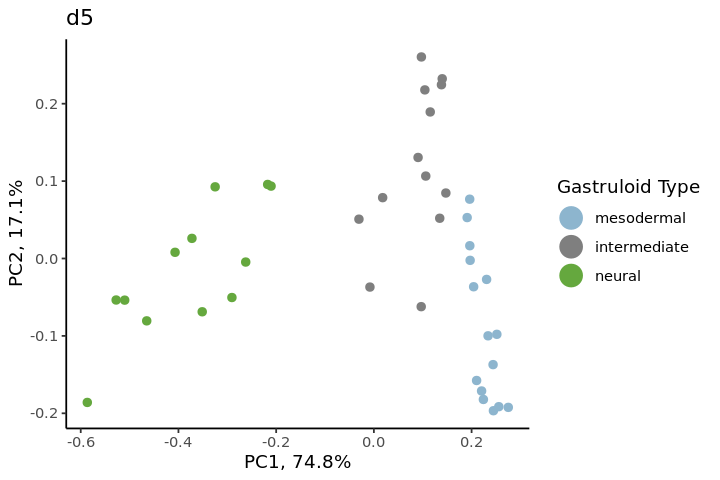

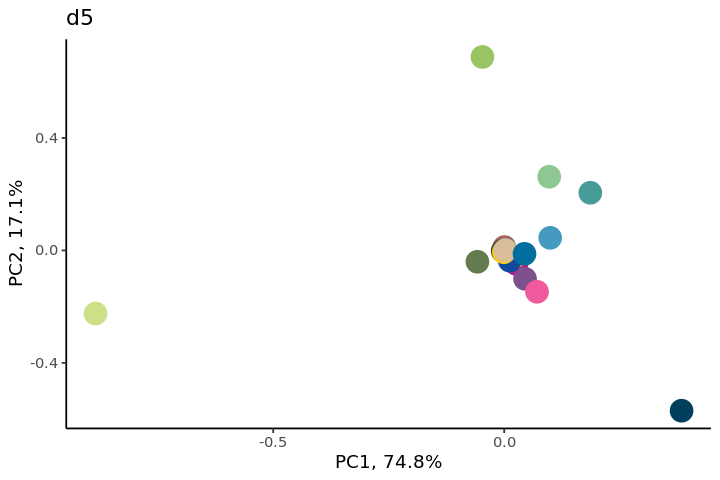

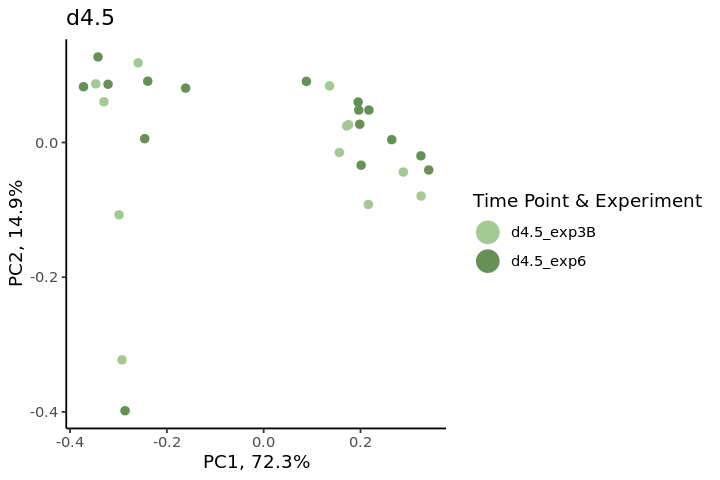

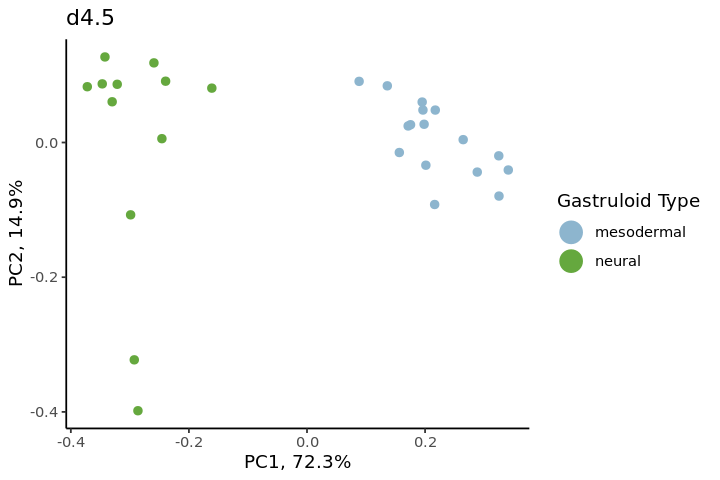

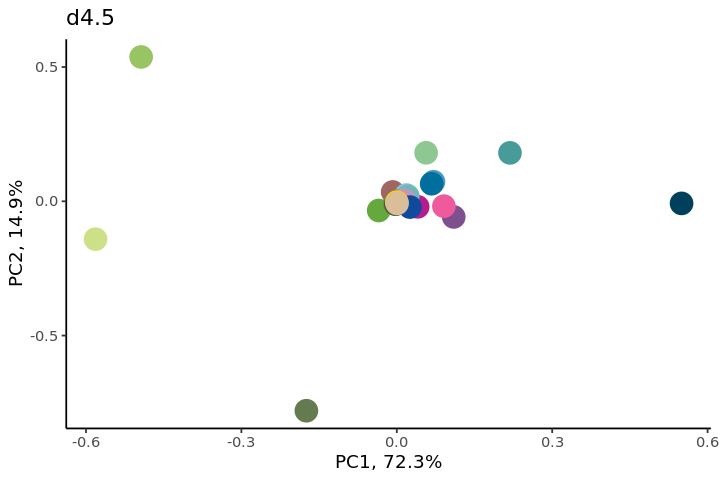

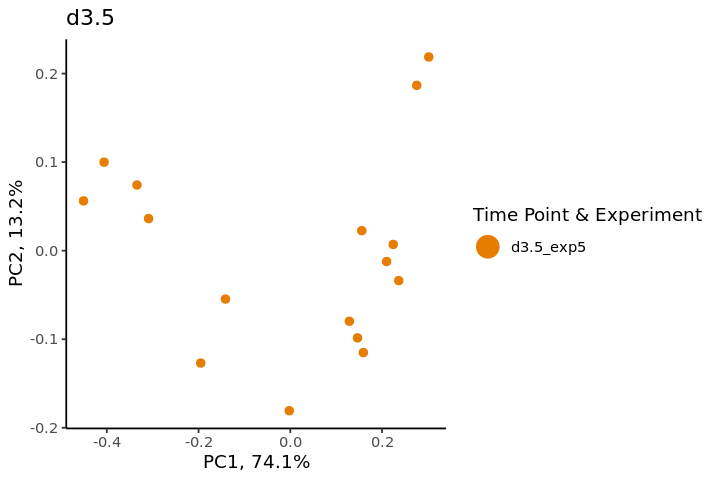

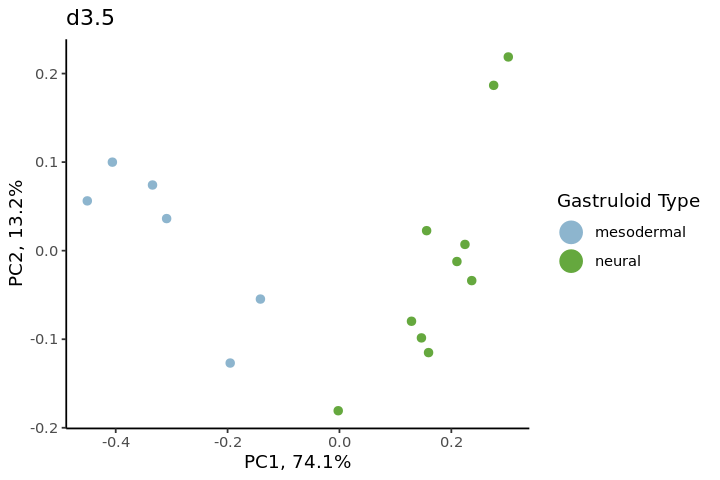

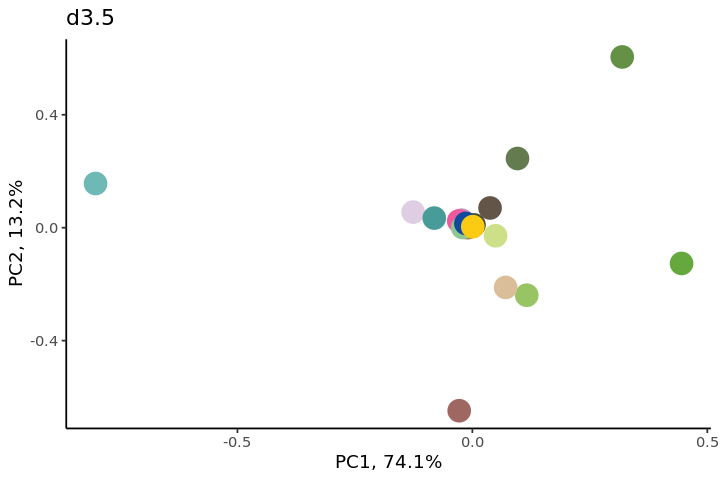

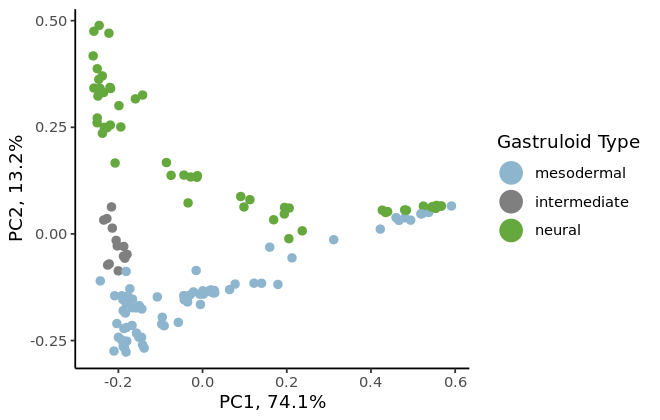

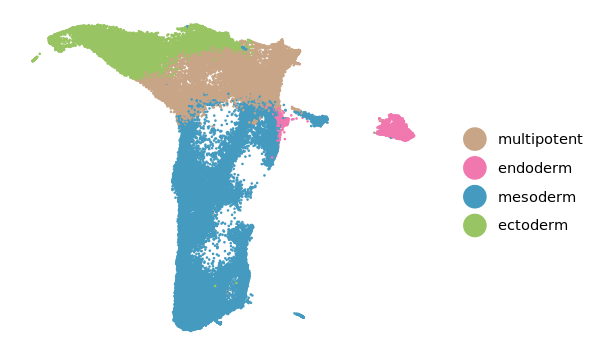

In [10]:
############################
## Supplementary Figure 6 ##
############################

## Supplementary Figure 6A-O
options(repr.plot.width=6, repr.plot.height=4)
ct_pca_list <- list()
gastruloid_pca_list <- list()
PC1_var_list <- list()
PC2_var_list <- list()
PC_loadings_list <- list()
for (tp in MULTI_timepoints) {
  to.plot <- g_meta[(timepoint==tp) & (!is.na(cluster) & (cluster != "unlabelled")) & (!is.na(MULTI_class)) & (MULTI_class!="Doublet") & (MULTI_class!="Negative") & (MULTI_class!="unidentifiable")][,.N,by=c("cluster","MULTI_class")]
  toplot_dcast <- dcast(to.plot, cluster ~ MULTI_class)
  toplot_dcast <- as.matrix(toplot_dcast, rownames="cluster")
  toplot_dcast[is.na(toplot_dcast)] = 0
  toplot_dcast <- t(t(toplot_dcast)/colSums(toplot_dcast))
  ct_pca_list[[tp]] <- prcomp(t(as.matrix(toplot_dcast)), scale = FALSE)
  gastruloid_pca_list[[tp]] <- data.table(ct_pca_list[[tp]]$x)
  gastruloid_pca_list[[tp]]$MULTI_class <- colnames(toplot_dcast)
  PC1_var_list[[tp]] <- round(((ct_pca_list[[tp]][[1]]**2)/sum(ct_pca_list[[tp]][[1]]**2))[[1]],3)*100
  PC2_var_list[[tp]] <- round(((ct_pca_list[[tp]][[1]]**2)/sum(ct_pca_list[[tp]][[1]]**2))[[2]],3)*100
}
for (tp in MULTI_timepoints) {
  to.plot <- merge(gastruloid_pca_list[[tp]], unique(g_meta[,c("MULTI_class", "experiment", "timepoint")]), by="MULTI_class", all.y=FALSE)
  to.plot$timepoint_exp <- factor(paste0(to.plot$timepoint, '_', unlist(lapply(strsplit(to.plot$experiment, '_'), function(s) s[[1]]))), levels=names(tp_experiment_colours))
  p <- ggplot(to.plot, aes(x=PC1, y=PC2, colour=timepoint_exp)) +
    geom_point(size=2) +
    labs(x=paste0("PC1, ",PC1_var_list[[tp]],"%"),
         y=paste0("PC2, ",PC2_var_list[[tp]],"%")) +
    guides(colour = guide_legend(override.aes = list(size=6))) +
    ggtitle(tp) +
    scale_colour_manual(values = tp_experiment_colours[names(tp_experiment_colours) %in% unique(to.plot$timepoint_exp)], name = "Time Point & Experiment") +
    theme_classic()
  print(p)
  ggsave(
    paste0('/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/SuppFig6/', tp, '_tpexp.pdf'),
    plot = p,
    device = 'pdf',
    width = 6,
    height = 4,
    units = "in"
  )
  
  to.plot <- merge(gastruloid_pca_list[[tp]], unique(g_meta[,c("MULTI_class", "experiment", "gastr_type")]), by="MULTI_class", all.y=FALSE)
  p <- ggplot(to.plot, aes(x=PC1, y=PC2, colour=gastr_type)) +
    geom_point(size=2) +
    labs(x=paste0("PC1, ",PC1_var_list[[tp]],"%"),
         y=paste0("PC2, ",PC2_var_list[[tp]],"%")) +
    guides(colour = guide_legend(override.aes = list(size=6))) +
    ggtitle(tp) +
    scale_colour_manual(values = gastr_type_colours[gastr_type_order[gastr_type_order %in% to.plot$gastr_type]], name = "Gastruloid Type") +
    theme_classic() 
  print(p)
  ggsave(
    paste0('/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/SuppFig6/', tp, '_gt.pdf'),
    plot = p,
    device = 'pdf',
    width = 6,
    height = 4,
    units = "in"
  )
  
  PC_loadings_list[[tp]] <- as.data.table(ct_pca_list[[tp]]$rotation)
  PC_loadings_list[[tp]]$cluster <- rownames(ct_pca_list[[tp]]$rotation)
  p <- ggplot(PC_loadings_list[[tp]], aes(x=PC1, y=PC2, colour=cluster)) +
    geom_point(size=6) +
    scale_colour_manual(values = cluster_colours[cluster_order], name = "Cluster") +
    guides(colour = guide_legend(override.aes = list(size=6))) +
    ggtitle(tp) +
    labs(x=paste0("PC1, ",PC1_var_list[[tp]],"%"),
         y=paste0("PC2, ",PC2_var_list[[tp]],"%"))+
    theme_classic() +
    theme(legend.position = 'none')
  print(p)
  ggsave(
    paste0('/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/SuppFig6/', tp, '_featloads.pdf'),
    plot = p,
    device = 'pdf',
    width = 4,
    height = 4,
    units = "in"
  )
  
}

## Supplementary Figure 6P
options(repr.plot.width=5.5, repr.plot.height=3.5)
to.plot <- merge(gastruloid_pca, g_meta[,.N,by=c("MULTI_class", "timepoint", "gastr_type")], by="MULTI_class", all.x=TRUE)
p <- ggplot(to.plot, aes(x=PC1, y=PC2, colour=gastr_type)) +
  geom_point(size=2) +
  labs(x=paste0("PC1, ",PC1_var_list[[tp]],"%"),
       y=paste0("PC2, ",PC2_var_list[[tp]],"%")) +
  scale_colour_manual(values = gastr_type_colours[gastr_type_order], name = "Gastruloid Type") +
  theme_classic()  +
  guides(colour = guide_legend(override.aes = list(size=6)))
print(p)
ggsave(
  paste0('/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/SuppFig6/P.pdf'),
  plot = p,
  device = 'pdf',
  width = 5.5,
  height = 3.5,
  units = "in"
)

## Supplementary Figure 6Q
options(repr.plot.width=5, repr.plot.height=3)
to.plot <- g_meta
to.plot$cluster <- unlist(lapply(to.plot$cluster, function(c) inv_cluster_grouping[[c]]))
to.plot$cluster = factor(to.plot$cluster, levels=rev(group_order))
p <- ggplot(data=to.plot, mapping = aes(x=X1, y=X2, colour=cluster)) +
  geom_point(size=0.1, alpha=1) +
  #ggrastr::geom_point_rast(size=0.1, alpha=1) +
  labs(x="UMAP Dimension 1", y="UMAP Dimension 2") +
  scale_colour_manual(values = group_colours[group_order], name = "") +
  guides(colour = guide_legend(override.aes = list(size=6))) +
  theme_classic() +
  theme(line = element_blank(),
        axis.text=element_blank(),
        title = element_blank())
print(p)
ggsave(
  paste0('/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/SuppFig6/Q.pdf'),
  plot = p,
  device = 'pdf',
  width = 5,
  height = 3,
  units = "in"
)

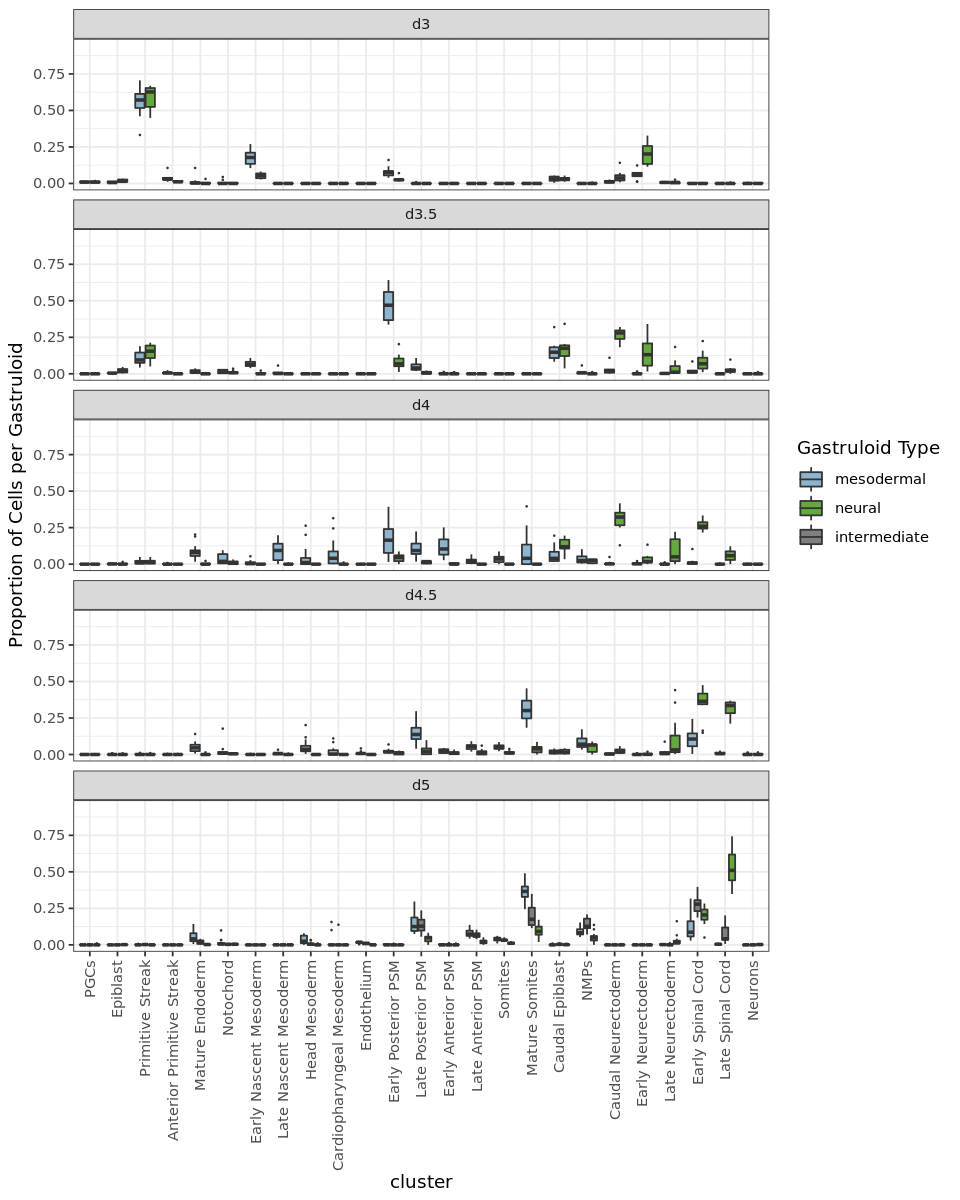

In [11]:
############################
## Supplementary Figure 7 ##
############################

## Supplementary Figure 7
to.plot1 <- g_meta[(timepoint %in% MULTI_timepoints) & (cluster != 'unlabelled') & (gastr_type %in% gastr_type_order), c("cell", "cluster", "MULTI_class", "gastr_type", "timepoint")]
to.plot1 <- to.plot1[, sum := .N, by = MULTI_class][, prop := .N, by = c("MULTI_class", "cluster")][, prop := prop/sum][, sum := NULL][,cell := NULL] %>% unique
to.plot <- dcast(to.plot1, cluster~MULTI_class, value.var = 'prop', fun.aggregate = sum) %>% melt(id.vars = "cluster")
to.plot <- setnames(to.plot, c("variable", "value"), c("MULTI_class", "proportion"))
to.plot$gastr_type <- unlist(lapply(to.plot$MULTI_class, function(x) unique(to.plot1[MULTI_class == x]$gastr_type)))
to.plot$gastr_type <- factor(to.plot$gastr_type, levels=gastr_type_order)
to.plot$timepoint <- unlist(lapply(to.plot$MULTI_class, function(x) unique(to.plot1[MULTI_class == x]$timepoint)))
to.plot$cluster = factor(to.plot$cluster, levels=cluster_order)
options(repr.plot.width=8, repr.plot.height=10)
p <- ggplot(to.plot, aes(x=cluster, y=proportion, fill=gastr_type)) +
  geom_boxplot(outlier.size = 0.1, size=0.5) +
  scale_fill_manual(values = gastr_type_colours, name = "Gastruloid Type") +
  ylim(0,max(to.plot$proportion)+0.2) +
  labs(y="Proportion of Cells per Gastruloid") +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
  facet_wrap(~timepoint, ncol=1)
print(p)
ggsave(
  paste0('/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/SuppFig7/Fig.pdf'),
  plot = p,
  device = 'pdf',
  width = 8,
  height = 10,
  units = "in"
)

Using 'N' as value column. Use 'value.var' to override



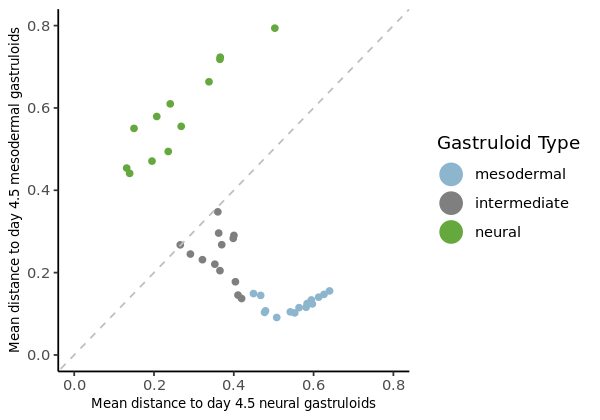

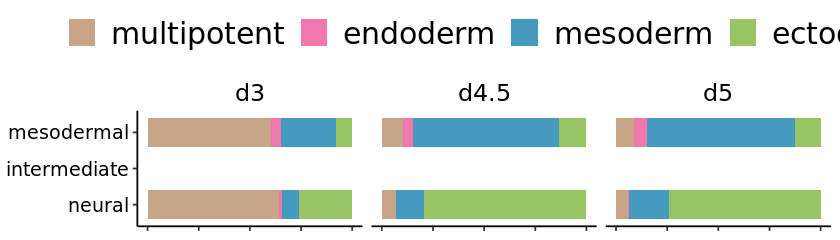

In [12]:
##############
## Figure 3 ##
##############

## Figure 3D
to.plot <- g_meta[(!is.na(cluster)) & (!is.na(MULTI_class)) & (MULTI_class!="Doublet") & (MULTI_class!="Negative") & (MULTI_class!="unidentifiable") & (timepoint %in% c("d4.5", "d5"))][,.N,by=c("cluster","MULTI_class")]
toplot_dcast <- dcast(to.plot, cluster ~ MULTI_class)
toplot_dcast <- as.matrix(toplot_dcast, rownames="cluster")
toplot_dcast[is.na(toplot_dcast)] = 0
toplot_dcast <- t(t(toplot_dcast)/colSums(toplot_dcast))
ct_sub_pca <- prcomp(t(as.matrix(toplot_dcast)), scale = FALSE)
gastruloid_sub_pca <- data.table(ct_sub_pca$x)
gastruloid_sub_pca$MULTI_class <- colnames(toplot_dcast)
gastruloid_sub_pca <- data.table(ct_sub_pca$x)
gastruloid_sub_pca$MULTI_class <- colnames(toplot_dcast)
to.plot <- merge(gastruloid_sub_pca, g_meta[,.N,by=c("MULTI_class", "timepoint", "experiment", "gastr_type")], by="MULTI_class", all.x=TRUE)
gastr_dist_full <- dist(ct_sub_pca$x[,1:2], method="euclidean") %>% as.matrix
gastr_dist <- list()
groupA <- to.plot[(gastr_type == 'neural') & (timepoint=='d4.5')]$MULTI_class
groupB <- to.plot[(gastr_type == 'neural') & (timepoint=='d5')]$MULTI_class
gastr_dist[["neural_neural"]] <- data.frame(dist_neural = colMeans(gastr_dist_full[groupA, groupB]),
                                            gastr = groupB,
                                            gastr_type = "neural"
)
groupA <- to.plot[(gastr_type == 'mesodermal') & (timepoint=='d4.5')]$MULTI_class
groupB <- to.plot[(gastr_type == 'neural') & (timepoint=='d5')]$MULTI_class
gastr_dist[["meso_neural"]] <- data.frame(dist_meso = colMeans(gastr_dist_full[groupA, groupB]),
                                          gastr = groupB,
                                          gastr_type = "neural"
)
gastr_dist[["neural"]] <- merge(gastr_dist[["neural_neural"]], gastr_dist[["meso_neural"]], by=c("gastr", "gastr_type"), all=TRUE)
groupA <- to.plot[(gastr_type == 'neural') & (timepoint=='d4.5')]$MULTI_class
groupB <- to.plot[(gastr_type == 'mesodermal') & (timepoint=='d5')]$MULTI_class
gastr_dist[["neural_meso"]] <- data.frame(dist_neural = colMeans(gastr_dist_full[groupA, groupB]),
                                          gastr = groupB,
                                          gastr_type = "mesodermal"
)
groupA <- to.plot[(gastr_type == 'mesodermal') & (timepoint=='d4.5')]$MULTI_class
groupB <- to.plot[(gastr_type == 'mesodermal') & (timepoint=='d5')]$MULTI_class
gastr_dist[["meso_meso"]] <- data.frame(dist_meso = colMeans(gastr_dist_full[groupA, groupB]),
                                        gastr = groupB,
                                        gastr_type = "mesodermal"
)
gastr_dist[["meso"]] <- merge(gastr_dist[["neural_meso"]], gastr_dist[["meso_meso"]], by=c("gastr", "gastr_type"), all=TRUE)
groupA <- to.plot[(gastr_type == 'neural') & (timepoint=='d4.5')]$MULTI_class
groupB <- to.plot[(gastr_type == 'intermediate') & (timepoint=='d5')]$MULTI_class
gastr_dist[["neural_int"]] <- data.frame(dist_neural = colMeans(gastr_dist_full[groupA, groupB]),
                                         gastr = groupB,
                                         gastr_type = "intermediate"
)
groupA <- to.plot[(gastr_type == 'mesodermal') & (timepoint=='d4.5')]$MULTI_class
groupB <- to.plot[(gastr_type == 'intermediate') & (timepoint=='d5')]$MULTI_class
gastr_dist[["meso_int"]] <- data.frame(dist_meso = colMeans(gastr_dist_full[groupA, groupB]),
                                       gastr = groupB,
                                       gastr_type = "intermediate"
)
gastr_dist[["int"]] <- merge(gastr_dist[["neural_int"]], gastr_dist[["meso_int"]], by=c("gastr", "gastr_type"), all=TRUE)
gastr_dist <- rbindlist(list(gastr_dist[["neural"]], gastr_dist[["meso"]], gastr_dist[["int"]]))
options(repr.plot.width=5, repr.plot.height=3.5)
p <- ggplot(gastr_dist, aes(x=dist_neural, y=dist_meso, colour = gastr_type)) +
  geom_point(size=1.5) +
  scale_colour_manual(values = gastr_type_colours[gastr_type_order], name = "Gastruloid Type") +
  guides(colour = guide_legend(override.aes = list(size=6))) +
  ylim(0,0.8) +
  xlim(0,0.8) +
  geom_abline(intercept = 0, slope=1, colour='grey', linetype='dashed') +
  labs(x="Mean distance to day 4.5 neural gastruloids", y="Mean distance to day 4.5 mesodermal gastruloids") +
  theme_classic() +
  theme(axis.title = element_text(size = 8))
print(p)
ggsave(
  paste0('/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/Fig3/D.pdf'),
  plot = p,
  device = 'pdf',
  width = 5,
  height = 3.5,
  units = "in"
)

## Figure 3E
to.plot <- g_meta[(gastr_type %in% c("mesodermal", "neural")) & (cluster %in% cluster_order) & (timepoint %in% c("d3", "d4.5", "d5")) ,.N,by=c("cluster","gastr_type", "timepoint")]
to.plot$cluster <- unlist(lapply(to.plot$cluster, function(c) inv_cluster_grouping[[c]]))
to.plot$gastr_type = factor(to.plot$gastr_type, levels=rev(gastr_type_order))
to.plot$timepoint = factor(to.plot$timepoint, levels=timepoint_order)
to.plot$cluster = factor(to.plot$cluster, levels=rev(group_order))
options(repr.plot.width=7, repr.plot.height=2)
p <- ggplot(to.plot, aes_string(x="gastr_type", y="N", fill="cluster")) +
  scale_x_discrete(drop=FALSE) + 
  labs(y="Proportion of cells") +
  theme_classic() +
  scale_fill_manual(values = group_colours[group_order], name = "") +
  theme(
    strip.background = element_blank(),
    strip.text = element_text(color="black", size=rel(1.3)),
    axis.title.x = element_blank(),
    axis.title.y = element_blank(),
    axis.text.y = element_text(size=rel(1.3), color="black"),
    axis.text.x = element_blank(),
    legend.position="top",
    legend.title = element_text(size=18),
    legend.text = element_text(size=18)
  ) +
  geom_bar(stat="identity", position="fill", width = 0.8) +
  coord_flip() +
  facet_wrap(~timepoint, nrow=1)
print(p)
ggsave(
  paste0('/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/Fig3/E.pdf'),
  plot = p,
  device = 'pdf',
  width = 7,
  height = 2,
  units = "in"
)

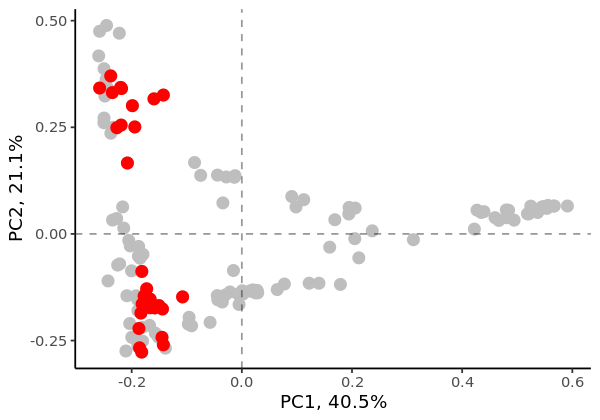

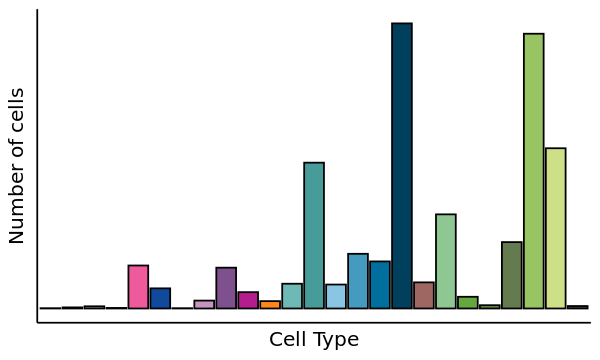

In [13]:
##############
## Figure 4 ##
##############

## Figure 4A
options(repr.plot.width=5, repr.plot.height=3.5)
to.plot <- merge(gastruloid_pca, g_meta[,.N,by=c("MULTI_class", "timepoint", "experiment")], by="MULTI_class", all.x=TRUE)
to.plot$timepoint <- factor(to.plot$timepoint, levels=timepoint_order)
p <- ggplot(data=to.plot[timepoint == "d4.5"], mapping = aes(PC1, y=PC2)) +
  geom_point(data=select(to.plot,-timepoint), colour="grey", size=3) +
  geom_point(size=3, colour='red') +
  labs(x=paste0("PC1, ",PC1_var,"%"),
       y=paste0("PC2, ",PC2_var,"%")) +
  geom_vline(xintercept = 0, linetype="dashed", alpha=0.4) +
  geom_hline(yintercept = 0, linetype="dashed", alpha=0.4) +
  scale_colour_manual(values = timepoint_colours[names(timepoint_colours) %in% unique(to.plot$timepoint)], name = "Time Point") +
  theme_classic()
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/Fig4/A.pdf',
  plot = p,
  width = 5,
  height = 3.5
)

## Figure 4B
options(repr.plot.width=5, repr.plot.height=3)
to.plot <- g_meta[(timepoint == 'd4.5')]
to.plot <- to.plot[sample(1:nrow(to.plot), 5000)]
to.plot <- to.plot[,.N,by=c("cluster","timepoint")]
to.plot$cluster <- factor(to.plot$cluster, levels=cluster_order)
p <- ggplot(to.plot, aes(x=cluster, y=N)) +
  scale_x_discrete(drop=FALSE) +
  labs(x="Cell Type", y="Number of cells") +
  theme_classic() +
  theme(
    legend.position = "none",
    strip.background = element_blank(),
    strip.text = element_text(color="black", size=rel(1.3)),
    axis.title = element_text(color="black", size=rel(1.1)),
    axis.text.y = element_text(size=rel(1.3), color="black"),
    axis.text.x = element_text(size=rel(1.1), color="black")
  ) +
  geom_bar(aes(fill=cluster), stat="identity", color="black") + 
  scale_fill_manual(values=cluster_colours, drop=F) +
  theme(axis.text.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.x = element_blank(),
        axis.ticks.y = element_blank()
  )
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/Fig4/B.pdf',
  plot = p,
  width = 5,
  height = 2
)